In [1]:
%precision 3
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spla
# the following allows us to plot triangles indicating convergence order
from matplotlib import cm
# and we will create some animations!
import matplotlib.animation as animation
from IPython.display import HTML
from pprint import pprint

In [2]:
def pressure_poisson_jacobi(p, dx, dy, RHS, rtol = 1.e-5, logs = False):
    """ Solve the pressure Poisson equation (PPE)
    using Jacobi iteration assuming mesh spacing of
    dx and dy (we assume at the moment that dx=dy)
    and the RHS function given by RHS.
    
    Assumes imposition of a Neumann BC on all boundaries.
    
    Return the pressure field.
    """
    # our code below is only currently for the case dx=dy
    assert dx==dy
    # iterate
    tol = 10.*rtol
    it = 0
    p_old = np.copy(p)
    
    imax = len(p)
    jmax = np.size(p)//imax
    
    while tol > rtol:
        it += 1
        #swap arrays without copying the data
        temp = p_old
        p_old = p
        p = temp
        
        for i in range(1,imax-1,1):
            for j in range(1,jmax-1,1):
                p[i, j] = 0.25*(p_old[i+1, j] + p_old[i-1, j] + p_old[i, j+1] + p_old[i,j-1] - (dx**2)*RHS[i, j])
    
        # apply zero pressure gradient Neumann boundary conditions
        for i in range(imax):
            p[i,0] = p[i,1]
            p[i,jmax-1] = p[i,jmax-2]
        for j in range(jmax):
            p[0,j] = p[1,j]
            p[imax-1,j] = p[imax-2,j]

        # fix pressure level - choose an arbitrary node to set p to
        # be zero, avoid the corners and set it to an interior location
        p[1,1] = 0

        # relative change in pressure
        tol = sl.norm(p - p_old)/np.maximum(1.0e-10,sl.norm(p))
        
    if logs: print('pressure solve iterations = {:4d}'.format(it))
    return p

In [3]:
def calculate_ppm_RHS(rho, u, v, dt, dx, dy):
    """ Calculate the RHS of the 
    Poisson equation resulting from the projection method.
    Use central differences for the first derivatives of u and v.
    """
    imax = len(p)
    jmax = np.size(p)//imax
    
    RHS = np.zeros_like(X)
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            RHS[i, j] = rho * ((1.0/dt) * ( (u[i+1, j] - u[i-1, j]) / (2*dx) + (v[i, j+1] - v[i, j-1]) / (2*dy)))
    return RHS


def project_velocity(rho, u, v, dt, dx, dy, p):
    """ Update the velocity to be divergence free using the pressure.
    """
    imax = len(p)
    jmax = np.size(p)//imax
    
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            u[i, j] = u[i, j] - dt * (1./rho) * (
                (p[i+1, j] - p[i-1, j])/(2*dx) )
            v[i, j] = v[i, j] - dt * (1./rho) * (
                (p[i, j+1] - p[i, j-1])/(2*dy) )    
    return u, v

def calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy):
    """ Calculate the intermediate velocities.
    """
    imax = len(u)
    jmax = np.size(u)//imax
    
    for i in range(1,imax-1,1):
        for j in range(1,jmax-1,1):
            #viscous (diffusive) term first
            u[i,j] = u_old[i,j] + dt * nu * ((u_old[i+1,j]+u_old[i-1,j]-2.*u_old[i,j])/(dx**2)
                                             +(u_old[i,j+1]+u_old[i,j-1]-2.*u_old[i,j])/(dy**2))
            v[i,j] = v_old[i,j] + dt * nu * ((v_old[i+1,j]+v_old[i-1,j]-2.*v_old[i,j])/(dx**2)
                                             +(v_old[i,j+1]+v_old[i,j-1]-2.*v_old[i,j])/(dy**2))
            #add the momentum advection terms using upwinding
            if (u_old[i,j]>0.0):
                u[i,j] -= dt*(u_old[i,j]*(u_old[i,j]-u_old[i-1,j])/dx)
                v[i,j] -= dt*(u_old[i,j]*(v_old[i,j]-v_old[i-1,j])/dx)
            else:
                u[i,j] -= dt*(u_old[i,j]*(u_old[i+1,j]-u_old[i,j])/dx)
                v[i,j] -= dt*(u_old[i,j]*(v_old[i+1,j]-v_old[i,j])/dx)

            if (v_old[i,j]>0.0):
                u[i,j] -= dt*(v_old[i,j]*(u_old[i,j]-u_old[i,j-1])/dy)
                v[i,j] -= dt*(v_old[i,j]*(v_old[i,j]-v_old[i,j-1])/dy)
            else:
                u[i,j] -= dt*(v_old[i,j]*(u_old[i,j+1]-u_old[i,j])/dy)
                v[i,j] -= dt*(v_old[i,j]*(v_old[i,j+1]-v_old[i,j])/dy)
                
    return u, v

In [4]:
def solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol = 1.e-5, logs = False):
    """ Solve the incompressible Navier-Stokes equations
    using a lot of the numerical choices and approaches we've seen
    earlier in this lecture.
    """
    t = 0
    
    u_old = u.copy()
    v_old = v.copy()
    
    while t < t_end:
        t += dt
        if logs: print('\nTime = {:.8f}'.format(t))

        # calculate intermediate velocities
        u, v = calculate_intermediate_velocity(nu, u, v, u_old, v_old, dt, dx, dy)
        # PPM
        # calculate RHS for the pressure Poisson problem
        p_RHS = calculate_ppm_RHS(rho, u, v, dt, dx, dy)
        # compute pressure - note that we use the previous p as an initial guess to the solution
        p = pressure_poisson_jacobi(p, dx, dy, p_RHS, 1.e-5, logs)
        # project velocity
        u, v = project_velocity(rho, u, v, dt, dx, dy, p)
        
        if logs:
            print('norm(u) = {0:.8f}, norm(v) = {1:.8f}'.format(sl.norm(u),sl.norm(v)))
            print('Courant number: {0:.8f}'.format(np.max(np.sqrt(u**2+v**2)) * dt / dx ))
        
        # relative change in u and v
        tolu = sl.norm(u - u_old)/np.maximum(1.0e-10,sl.norm(u))
        tolv = sl.norm(v - v_old)/np.maximum(1.0e-10,sl.norm(v))
        if tolu < rtol and tolv < rtol: break
            
        #swap pointers without copying data
        temp = u_old
        u_old = u
        u = temp
        temp = v_old
        v_old = v
        v = temp
    return u, v, p

In [5]:
# physical parameters
rho = 1
nu = 1./10.

# define spatial mesh
# Size of rectangular domain
Lx = 1
Ly = Lx

# Number of grid points in each direction, including boundary nodes
Nx = 51
Ny = Nx

# hence the mesh spacing
dx = Lx/(Nx-1)
dy = Ly/(Ny-1)

# read the docs to see the ordering that mgrid gives us
X, Y = np.mgrid[0:Nx:1, 0:Ny:1]
X = dx*X
Y = dy*Y
# the following is an alternative to the three lines above
#X, Y = np.mgrid[0: Lx + 1e-10: dx, 0: Ly + 1e-10: dy]
# but without the need to add a "small" increment to ensure
# the Lx and Ly end points are included

# time stepping parameters
dt = 2.e-4
t_end = 2.0

# initialise independent variables
u = np.zeros_like(X)
v = np.zeros_like(X)
p = np.zeros_like(X)

# Apply Dirichlet BCs to u and v - the code doesn't touch
# these so we can do this once outside the time loop
u[:, -1]=1  # set velocity on cavity lid equal to 1
u[:, 0]=0
u[0, :]=0
u[-1, :]=0
v[:, -1]=0
v[:, 0]=0
v[0, :]=0
v[-1, :]=0

import time
start = time.time()
u, v, p = solve_NS(u, v, p, rho, nu, dt, t_end, dx, dy, rtol=1.e-6, logs = True)
end = time.time()
print('Time taken by calculation = ', end - start)


Time = 0.00020000
pressure solve iterations = 6287
norm(u) = 7.00800116, norm(v) = 0.03434456
Courant number: 0.01000000

Time = 0.00040000
pressure solve iterations = 11647
norm(u) = 7.02817911, norm(v) = 0.08291611
Courant number: 0.01000000

Time = 0.00060000
pressure solve iterations = 5096
norm(u) = 7.05640282, norm(v) = 0.13825832
Courant number: 0.01000000

Time = 0.00080000
pressure solve iterations = 2805
norm(u) = 7.08992394, norm(v) = 0.19662819
Courant number: 0.01000000

Time = 0.00100000
pressure solve iterations = 1746
norm(u) = 7.12685793, norm(v) = 0.25592212
Courant number: 0.01000000

Time = 0.00120000
pressure solve iterations =  857
norm(u) = 7.16589599, norm(v) = 0.31489009
Courant number: 0.01000000

Time = 0.00140000
pressure solve iterations =   59
norm(u) = 7.20612155, norm(v) = 0.37280050
Courant number: 0.01000000

Time = 0.00160000
pressure solve iterations =  177
norm(u) = 7.24687941, norm(v) = 0.42942175
Courant number: 0.01000000

Time = 0.00180000
pres

pressure solve iterations =  405
norm(u) = 8.75167752, norm(v) = 2.02260960
Courant number: 0.01000000

Time = 0.01380000
pressure solve iterations =  397
norm(u) = 8.76676524, norm(v) = 2.03749422
Courant number: 0.01000000

Time = 0.01400000
pressure solve iterations =  389
norm(u) = 8.78168271, norm(v) = 2.05222392
Courant number: 0.01000000

Time = 0.01420000
pressure solve iterations =  382
norm(u) = 8.79643368, norm(v) = 2.06680239
Courant number: 0.01000000

Time = 0.01440000
pressure solve iterations =  375
norm(u) = 8.81102175, norm(v) = 2.08123321
Courant number: 0.01000000

Time = 0.01460000
pressure solve iterations =  368
norm(u) = 8.82545042, norm(v) = 2.09551987
Courant number: 0.01000000

Time = 0.01480000
pressure solve iterations =  361
norm(u) = 8.83972305, norm(v) = 2.10966570
Courant number: 0.01000000

Time = 0.01500000
pressure solve iterations =  355
norm(u) = 8.85384294, norm(v) = 2.12367383
Courant number: 0.01000000

Time = 0.01520000
pressure solve iteration

pressure solve iterations =  158
norm(u) = 9.51230381, norm(v) = 2.79821959
Courant number: 0.01000000

Time = 0.02740000
pressure solve iterations =  155
norm(u) = 9.52071894, norm(v) = 2.80718118
Courant number: 0.01000000

Time = 0.02760000
pressure solve iterations =  154
norm(u) = 9.52907811, norm(v) = 2.81609337
Courant number: 0.01000000

Time = 0.02780000
pressure solve iterations =  153
norm(u) = 9.53738201, norm(v) = 2.82495670
Courant number: 0.01000000

Time = 0.02800000
pressure solve iterations =  151
norm(u) = 9.54563130, norm(v) = 2.83377182
Courant number: 0.01000000

Time = 0.02820000
pressure solve iterations =  149
norm(u) = 9.55382663, norm(v) = 2.84253934
Courant number: 0.01000000

Time = 0.02840000
pressure solve iterations =  148
norm(u) = 9.56196866, norm(v) = 2.85125974
Courant number: 0.01000000

Time = 0.02860000
pressure solve iterations =  146
norm(u) = 9.57005801, norm(v) = 2.85993362
Courant number: 0.01000000

Time = 0.02880000
pressure solve iteration

pressure solve iterations =   86
norm(u) = 9.98348557, norm(v) = 3.31773008
Courant number: 0.01000000

Time = 0.04100000
pressure solve iterations =   86
norm(u) = 9.98920147, norm(v) = 3.32427897
Courant number: 0.01000000

Time = 0.04120000
pressure solve iterations =   84
norm(u) = 9.99488943, norm(v) = 3.33080252
Courant number: 0.01000000

Time = 0.04140000
pressure solve iterations =   84
norm(u) = 10.00054973, norm(v) = 3.33730082
Courant number: 0.01000000

Time = 0.04160000
pressure solve iterations =   84
norm(u) = 10.00618260, norm(v) = 3.34377399
Courant number: 0.01000000

Time = 0.04180000
pressure solve iterations =   83
norm(u) = 10.01178827, norm(v) = 3.35022231
Courant number: 0.01000000

Time = 0.04200000
pressure solve iterations =   82
norm(u) = 10.01736695, norm(v) = 3.35664602
Courant number: 0.01000000

Time = 0.04220000
pressure solve iterations =   82
norm(u) = 10.02291889, norm(v) = 3.36304522
Courant number: 0.01000000

Time = 0.04240000
pressure solve iter

pressure solve iterations =   55
norm(u) = 10.31421649, norm(v) = 3.70830545
Courant number: 0.01000000

Time = 0.05440000
pressure solve iterations =   55
norm(u) = 10.31847399, norm(v) = 3.71349985
Courant number: 0.01000000

Time = 0.05460000
pressure solve iterations =   54
norm(u) = 10.32271462, norm(v) = 3.71867828
Courant number: 0.01000000

Time = 0.05480000
pressure solve iterations =   54
norm(u) = 10.32693851, norm(v) = 3.72384081
Courant number: 0.01000000

Time = 0.05500000
pressure solve iterations =   55
norm(u) = 10.33114581, norm(v) = 3.72898738
Courant number: 0.01000000

Time = 0.05520000
pressure solve iterations =   53
norm(u) = 10.33533656, norm(v) = 3.73411831
Courant number: 0.01000000

Time = 0.05540000
pressure solve iterations =   53
norm(u) = 10.33951089, norm(v) = 3.73923363
Courant number: 0.01000000

Time = 0.05560000
pressure solve iterations =   53
norm(u) = 10.34366893, norm(v) = 3.74433340
Courant number: 0.01000000

Time = 0.05580000
pressure solve i

pressure solve iterations =   39
norm(u) = 10.57016034, norm(v) = 4.02921223
Courant number: 0.01000000

Time = 0.06800000
pressure solve iterations =   38
norm(u) = 10.57348059, norm(v) = 4.03349819
Courant number: 0.01000000

Time = 0.06820000
pressure solve iterations =   38
norm(u) = 10.57678963, norm(v) = 4.03777303
Courant number: 0.01000000

Time = 0.06840000
pressure solve iterations =   37
norm(u) = 10.58008751, norm(v) = 4.04203690
Courant number: 0.01000000

Time = 0.06860000
pressure solve iterations =   39
norm(u) = 10.58337436, norm(v) = 4.04628961
Courant number: 0.01000000

Time = 0.06880000
pressure solve iterations =   37
norm(u) = 10.58665016, norm(v) = 4.05053142
Courant number: 0.01000000

Time = 0.06900000
pressure solve iterations =   37
norm(u) = 10.58991499, norm(v) = 4.05476237
Courant number: 0.01000000

Time = 0.06920000
pressure solve iterations =   37
norm(u) = 10.59316891, norm(v) = 4.05898247
Courant number: 0.01000000

Time = 0.06940000
pressure solve i

pressure solve iterations =   28
norm(u) = 10.77311393, norm(v) = 4.29771612
Courant number: 0.01000000

Time = 0.08160000
pressure solve iterations =   28
norm(u) = 10.77579003, norm(v) = 4.30135019
Courant number: 0.01000000

Time = 0.08180000
pressure solve iterations =   28
norm(u) = 10.77845816, norm(v) = 4.30497601
Courant number: 0.01000000

Time = 0.08200000
pressure solve iterations =   29
norm(u) = 10.78111840, norm(v) = 4.30859351
Courant number: 0.01000000

Time = 0.08220000
pressure solve iterations =   27
norm(u) = 10.78377072, norm(v) = 4.31220294
Courant number: 0.01000000

Time = 0.08240000
pressure solve iterations =   28
norm(u) = 10.78641518, norm(v) = 4.31580420
Courant number: 0.01000000

Time = 0.08260000
pressure solve iterations =   28
norm(u) = 10.78905184, norm(v) = 4.31939730
Courant number: 0.01000000

Time = 0.08280000
pressure solve iterations =   27
norm(u) = 10.79168069, norm(v) = 4.32298239
Courant number: 0.01000000

Time = 0.08300000
pressure solve i

pressure solve iterations =   23
norm(u) = 10.93860584, norm(v) = 4.52754116
Courant number: 0.01000000

Time = 0.09520000
pressure solve iterations =   21
norm(u) = 10.94081321, norm(v) = 4.53068027
Courant number: 0.01000000

Time = 0.09540000
pressure solve iterations =   22
norm(u) = 10.94301467, norm(v) = 4.53381293
Courant number: 0.01000000

Time = 0.09560000
pressure solve iterations =   22
norm(u) = 10.94521022, norm(v) = 4.53693918
Courant number: 0.01000000

Time = 0.09580000
pressure solve iterations =   21
norm(u) = 10.94739986, norm(v) = 4.54005913
Courant number: 0.01000000

Time = 0.09600000
pressure solve iterations =   22
norm(u) = 10.94958366, norm(v) = 4.54317269
Courant number: 0.01000000

Time = 0.09620000
pressure solve iterations =   21
norm(u) = 10.95176160, norm(v) = 4.54627997
Courant number: 0.01000000

Time = 0.09640000
pressure solve iterations =   22
norm(u) = 10.95393374, norm(v) = 4.54938089
Courant number: 0.01000000

Time = 0.09660000
pressure solve i

pressure solve iterations =   17
norm(u) = 11.07442817, norm(v) = 4.72466170
Courant number: 0.01000000

Time = 0.10860000
pressure solve iterations =   17
norm(u) = 11.07628490, norm(v) = 4.72741502
Courant number: 0.01000000

Time = 0.10880000
pressure solve iterations =   18
norm(u) = 11.07813706, norm(v) = 4.73016312
Courant number: 0.01000000

Time = 0.10900000
pressure solve iterations =   18
norm(u) = 11.07998466, norm(v) = 4.73290601
Courant number: 0.01000000

Time = 0.10920000
pressure solve iterations =   17
norm(u) = 11.08182768, norm(v) = 4.73564381
Courant number: 0.01000000

Time = 0.10940000
pressure solve iterations =   17
norm(u) = 11.08366615, norm(v) = 4.73837652
Courant number: 0.01000000

Time = 0.10960000
pressure solve iterations =   17
norm(u) = 11.08550008, norm(v) = 4.74110416
Courant number: 0.01000000

Time = 0.10980000
pressure solve iterations =   17
norm(u) = 11.08732950, norm(v) = 4.74382672
Courant number: 0.01000000

Time = 0.11000000
pressure solve i

pressure solve iterations =   15
norm(u) = 11.19098875, norm(v) = 4.90084884
Courant number: 0.01000000

Time = 0.12220000
pressure solve iterations =   14
norm(u) = 11.19256701, norm(v) = 4.90328320
Courant number: 0.01000000

Time = 0.12240000
pressure solve iterations =   14
norm(u) = 11.19414163, norm(v) = 4.90571333
Courant number: 0.01000000

Time = 0.12260000
pressure solve iterations =   15
norm(u) = 11.19571265, norm(v) = 4.90813914
Courant number: 0.01000000

Time = 0.12280000
pressure solve iterations =   14
norm(u) = 11.19728004, norm(v) = 4.91056075
Courant number: 0.01000000

Time = 0.12300000
pressure solve iterations =   14
norm(u) = 11.19884383, norm(v) = 4.91297816
Courant number: 0.01000000

Time = 0.12320000
pressure solve iterations =   14
norm(u) = 11.20040403, norm(v) = 4.91539138
Courant number: 0.01000000

Time = 0.12340000
pressure solve iterations =   14
norm(u) = 11.20196065, norm(v) = 4.91780041
Courant number: 0.01000000

Time = 0.12360000
pressure solve i

norm(u) = 11.28922336, norm(v) = 5.05506544
Courant number: 0.01000000

Time = 0.13560000
pressure solve iterations =   12
norm(u) = 11.29058189, norm(v) = 5.05723818
Courant number: 0.01000000

Time = 0.13580000
pressure solve iterations =   11
norm(u) = 11.29193743, norm(v) = 5.05940743
Courant number: 0.01000000

Time = 0.13600000
pressure solve iterations =   13
norm(u) = 11.29329008, norm(v) = 5.06157299
Courant number: 0.01000000

Time = 0.13620000
pressure solve iterations =   12
norm(u) = 11.29463980, norm(v) = 5.06373499
Courant number: 0.01000000

Time = 0.13640000
pressure solve iterations =   11
norm(u) = 11.29598657, norm(v) = 5.06589352
Courant number: 0.01000000

Time = 0.13660000
pressure solve iterations =   12
norm(u) = 11.29733044, norm(v) = 5.06804848
Courant number: 0.01000000

Time = 0.13680000
pressure solve iterations =   12
norm(u) = 11.29867141, norm(v) = 5.07019988
Courant number: 0.01000000

Time = 0.13700000
pressure solve iterations =   12
norm(u) = 11.300

pressure solve iterations =   10
norm(u) = 11.37648077, norm(v) = 5.19702095
Courant number: 0.01000000

Time = 0.14940000
pressure solve iterations =   11
norm(u) = 11.37765492, norm(v) = 5.19896565
Courant number: 0.01000000

Time = 0.14960000
pressure solve iterations =    9
norm(u) = 11.37882661, norm(v) = 5.20090741
Courant number: 0.01000000

Time = 0.14980000
pressure solve iterations =   11
norm(u) = 11.37999593, norm(v) = 5.20284605
Courant number: 0.01000000

Time = 0.15000000
pressure solve iterations =   10
norm(u) = 11.38116284, norm(v) = 5.20478167
Courant number: 0.01000000

Time = 0.15020000
pressure solve iterations =   10
norm(u) = 11.38232735, norm(v) = 5.20671427
Courant number: 0.01000000

Time = 0.15040000
pressure solve iterations =   10
norm(u) = 11.38348948, norm(v) = 5.20864386
Courant number: 0.01000000

Time = 0.15060000
pressure solve iterations =   10
norm(u) = 11.38464922, norm(v) = 5.21057045
Courant number: 0.01000000

Time = 0.15080000
pressure solve i

pressure solve iterations =    9
norm(u) = 11.45216115, norm(v) = 5.32440471
Courant number: 0.01000000

Time = 0.16320000
pressure solve iterations =    9
norm(u) = 11.45318316, norm(v) = 5.32615422
Courant number: 0.01000000

Time = 0.16340000
pressure solve iterations =    8
norm(u) = 11.45420314, norm(v) = 5.32790117
Courant number: 0.01000000

Time = 0.16360000
pressure solve iterations =    9
norm(u) = 11.45522113, norm(v) = 5.32964547
Courant number: 0.01000000

Time = 0.16380000
pressure solve iterations =    9
norm(u) = 11.45623713, norm(v) = 5.33138713
Courant number: 0.01000000

Time = 0.16400000
pressure solve iterations =    8
norm(u) = 11.45725112, norm(v) = 5.33312624
Courant number: 0.01000000

Time = 0.16420000
pressure solve iterations =    9
norm(u) = 11.45826314, norm(v) = 5.33486271
Courant number: 0.01000000

Time = 0.16440000
pressure solve iterations =    9
norm(u) = 11.45927319, norm(v) = 5.33659655
Courant number: 0.01000000

Time = 0.16460000
pressure solve i

pressure solve iterations =    7
norm(u) = 11.51643409, norm(v) = 5.43607176
Courant number: 0.01000000

Time = 0.17660000
pressure solve iterations =    8
norm(u) = 11.51733232, norm(v) = 5.43765679
Courant number: 0.01000000

Time = 0.17680000
pressure solve iterations =    8
norm(u) = 11.51822887, norm(v) = 5.43923948
Courant number: 0.01000000

Time = 0.17700000
pressure solve iterations =    7
norm(u) = 11.51912371, norm(v) = 5.44081995
Courant number: 0.01000000

Time = 0.17720000
pressure solve iterations =    7
norm(u) = 11.52001684, norm(v) = 5.44239817
Courant number: 0.01000000

Time = 0.17740000
pressure solve iterations =    8
norm(u) = 11.52090831, norm(v) = 5.44397407
Courant number: 0.01000000

Time = 0.17760000
pressure solve iterations =    8
norm(u) = 11.52179812, norm(v) = 5.44554765
Courant number: 0.01000000

Time = 0.17780000
pressure solve iterations =    7
norm(u) = 11.52268623, norm(v) = 5.44711901
Courant number: 0.01000000

Time = 0.17800000
pressure solve i

pressure solve iterations =    6
norm(u) = 11.57384853, norm(v) = 5.53884280
Courant number: 0.01000000

Time = 0.19020000
pressure solve iterations =    7
norm(u) = 11.57464027, norm(v) = 5.54028142
Courant number: 0.01000000

Time = 0.19040000
pressure solve iterations =    7
norm(u) = 11.57543057, norm(v) = 5.54171800
Courant number: 0.01000000

Time = 0.19060000
pressure solve iterations =    6
norm(u) = 11.57621941, norm(v) = 5.54315261
Courant number: 0.01000000

Time = 0.19080000
pressure solve iterations =    7
norm(u) = 11.57700682, norm(v) = 5.54458519
Courant number: 0.01000000

Time = 0.19100000
pressure solve iterations =    7
norm(u) = 11.57779282, norm(v) = 5.54601573
Courant number: 0.01000000

Time = 0.19120000
pressure solve iterations =    6
norm(u) = 11.57857736, norm(v) = 5.54744433
Courant number: 0.01000000

Time = 0.19140000
pressure solve iterations =    7
norm(u) = 11.57936049, norm(v) = 5.54887089
Courant number: 0.01000000

Time = 0.19160000
pressure solve i

pressure solve iterations =    6
norm(u) = 11.62595984, norm(v) = 5.63486738
Courant number: 0.01000000

Time = 0.20420000
pressure solve iterations =    6
norm(u) = 11.62665813, norm(v) = 5.63617318
Courant number: 0.01000000

Time = 0.20440000
pressure solve iterations =    6
norm(u) = 11.62735519, norm(v) = 5.63747719
Courant number: 0.01000000

Time = 0.20460000
pressure solve iterations =    6
norm(u) = 11.62805102, norm(v) = 5.63877942
Courant number: 0.01000000

Time = 0.20480000
pressure solve iterations =    6
norm(u) = 11.62874563, norm(v) = 5.64007987
Courant number: 0.01000000

Time = 0.20500000
pressure solve iterations =    6
norm(u) = 11.62943902, norm(v) = 5.64137854
Courant number: 0.01000000

Time = 0.20520000
pressure solve iterations =    5
norm(u) = 11.63013115, norm(v) = 5.64267551
Courant number: 0.01000000

Time = 0.20540000
pressure solve iterations =    6
norm(u) = 11.63082208, norm(v) = 5.64397070
Courant number: 0.01000000

Time = 0.20560000
pressure solve i

norm(u) = 11.67076656, norm(v) = 5.71975417
Courant number: 0.01000000

Time = 0.21780000
pressure solve iterations =    5
norm(u) = 11.67138686, norm(v) = 5.72094557
Courant number: 0.01000000

Time = 0.21800000
pressure solve iterations =    6
norm(u) = 11.67200613, norm(v) = 5.72213534
Courant number: 0.01000000

Time = 0.21820000
pressure solve iterations =    5
norm(u) = 11.67262431, norm(v) = 5.72332355
Courant number: 0.01000000

Time = 0.21840000
pressure solve iterations =    5
norm(u) = 11.67324143, norm(v) = 5.72451019
Courant number: 0.01000000

Time = 0.21860000
pressure solve iterations =    5
norm(u) = 11.67385749, norm(v) = 5.72569528
Courant number: 0.01000000

Time = 0.21880000
pressure solve iterations =    6
norm(u) = 11.67447251, norm(v) = 5.72687873
Courant number: 0.01000000

Time = 0.21900000
pressure solve iterations =    5
norm(u) = 11.67508647, norm(v) = 5.72806063
Courant number: 0.01000000

Time = 0.21920000
pressure solve iterations =    5
norm(u) = 11.675

pressure solve iterations =    5
norm(u) = 11.71118353, norm(v) = 5.79836952
Courant number: 0.01000000

Time = 0.23160000
pressure solve iterations =    5
norm(u) = 11.71173536, norm(v) = 5.79945724
Courant number: 0.01000000

Time = 0.23180000
pressure solve iterations =    4
norm(u) = 11.71228625, norm(v) = 5.80054361
Courant number: 0.01000000

Time = 0.23200000
pressure solve iterations =    5
norm(u) = 11.71283623, norm(v) = 5.80162854
Courant number: 0.01000000

Time = 0.23220000
pressure solve iterations =    5
norm(u) = 11.71338530, norm(v) = 5.80271203
Courant number: 0.01000000

Time = 0.23240000
pressure solve iterations =    5
norm(u) = 11.71393345, norm(v) = 5.80379410
Courant number: 0.01000000

Time = 0.23260000
pressure solve iterations =    4
norm(u) = 11.71448067, norm(v) = 5.80487481
Courant number: 0.01000000

Time = 0.23280000
pressure solve iterations =    5
norm(u) = 11.71502698, norm(v) = 5.80595409
Courant number: 0.01000000

Time = 0.23300000
pressure solve i

Courant number: 0.01000000

Time = 0.24480000
pressure solve iterations =    4
norm(u) = 11.74620064, norm(v) = 5.86821682
Courant number: 0.01000000

Time = 0.24500000
pressure solve iterations =    5
norm(u) = 11.74669454, norm(v) = 5.86921425
Courant number: 0.01000000

Time = 0.24520000
pressure solve iterations =    4
norm(u) = 11.74718762, norm(v) = 5.87021042
Courant number: 0.01000000

Time = 0.24540000
pressure solve iterations =    4
norm(u) = 11.74767988, norm(v) = 5.87120535
Courant number: 0.01000000

Time = 0.24560000
pressure solve iterations =    4
norm(u) = 11.74817133, norm(v) = 5.87219902
Courant number: 0.01000000

Time = 0.24580000
pressure solve iterations =    5
norm(u) = 11.74866200, norm(v) = 5.87319137
Courant number: 0.01000000

Time = 0.24600000
pressure solve iterations =    4
norm(u) = 11.74915185, norm(v) = 5.87418247
Courant number: 0.01000000

Time = 0.24620000
pressure solve iterations =    5
norm(u) = 11.74964093, norm(v) = 5.87517226
Courant number: 

norm(u) = 11.77757688, norm(v) = 5.93231309
Courant number: 0.01000000

Time = 0.25840000
pressure solve iterations =    4
norm(u) = 11.77801993, norm(v) = 5.93322912
Courant number: 0.01000000

Time = 0.25860000
pressure solve iterations =    5
norm(u) = 11.77846231, norm(v) = 5.93414391
Courant number: 0.01000000

Time = 0.25880000
pressure solve iterations =    3
norm(u) = 11.77890394, norm(v) = 5.93505762
Courant number: 0.01000000

Time = 0.25900000
pressure solve iterations =    4
norm(u) = 11.77934487, norm(v) = 5.93597018
Courant number: 0.01000000

Time = 0.25920000
pressure solve iterations =    4
norm(u) = 11.77978509, norm(v) = 5.93688158
Courant number: 0.01000000

Time = 0.25940000
pressure solve iterations =    4
norm(u) = 11.78022461, norm(v) = 5.93779183
Courant number: 0.01000000

Time = 0.25960000
pressure solve iterations =    4
norm(u) = 11.78066343, norm(v) = 5.93870093
Courant number: 0.01000000

Time = 0.25980000
pressure solve iterations =    4
norm(u) = 11.781

norm(u) = 11.80654886, norm(v) = 5.99289621
Courant number: 0.01000000

Time = 0.27220000
pressure solve iterations =    4
norm(u) = 11.80694590, norm(v) = 5.99373638
Courant number: 0.01000000

Time = 0.27240000
pressure solve iterations =    3
norm(u) = 11.80734231, norm(v) = 5.99457555
Courant number: 0.01000000

Time = 0.27260000
pressure solve iterations =    4
norm(u) = 11.80773810, norm(v) = 5.99541365
Courant number: 0.01000000

Time = 0.27280000
pressure solve iterations =    3
norm(u) = 11.80813324, norm(v) = 5.99625075
Courant number: 0.01000000

Time = 0.27300000
pressure solve iterations =    4
norm(u) = 11.80852778, norm(v) = 5.99708678
Courant number: 0.01000000

Time = 0.27320000
pressure solve iterations =    4
norm(u) = 11.80892172, norm(v) = 5.99792176
Courant number: 0.01000000

Time = 0.27340000
pressure solve iterations =    3
norm(u) = 11.80931501, norm(v) = 5.99875573
Courant number: 0.01000000

Time = 0.27360000
pressure solve iterations =    4
norm(u) = 11.809

pressure solve iterations =    3
norm(u) = 11.83253669, norm(v) = 6.04849810
Courant number: 0.01000000

Time = 0.28600000
pressure solve iterations =    4
norm(u) = 11.83289320, norm(v) = 6.04926964
Courant number: 0.01000000

Time = 0.28620000
pressure solve iterations =    3
norm(u) = 11.83324915, norm(v) = 6.05004027
Courant number: 0.01000000

Time = 0.28640000
pressure solve iterations =    3
norm(u) = 11.83360454, norm(v) = 6.05080997
Courant number: 0.01000000

Time = 0.28660000
pressure solve iterations =    3
norm(u) = 11.83395937, norm(v) = 6.05157875
Courant number: 0.01000000

Time = 0.28680000
pressure solve iterations =    4
norm(u) = 11.83431368, norm(v) = 6.05234654
Courant number: 0.01000000

Time = 0.28700000
pressure solve iterations =    3
norm(u) = 11.83466742, norm(v) = 6.05311341
Courant number: 0.01000000

Time = 0.28720000
pressure solve iterations =    3
norm(u) = 11.83502062, norm(v) = 6.05387936
Courant number: 0.01000000

Time = 0.28740000
pressure solve i


Time = 0.29920000
pressure solve iterations =    4
norm(u) = 11.85524903, norm(v) = 6.09816456
Courant number: 0.01000000

Time = 0.29940000
pressure solve iterations =    3
norm(u) = 11.85557069, norm(v) = 6.09887557
Courant number: 0.01000000

Time = 0.29960000
pressure solve iterations =    3
norm(u) = 11.85589186, norm(v) = 6.09958573
Courant number: 0.01000000

Time = 0.29980000
pressure solve iterations =    2
norm(u) = 11.85621251, norm(v) = 6.10029510
Courant number: 0.01000000

Time = 0.30000000
pressure solve iterations =    4
norm(u) = 11.85653270, norm(v) = 6.10100354
Courant number: 0.01000000

Time = 0.30020000
pressure solve iterations =    3
norm(u) = 11.85685240, norm(v) = 6.10171114
Courant number: 0.01000000

Time = 0.30040000
pressure solve iterations =    3
norm(u) = 11.85717161, norm(v) = 6.10241788
Courant number: 0.01000000

Time = 0.30060000
pressure solve iterations =    3
norm(u) = 11.85749034, norm(v) = 6.10312377
Courant number: 0.01000000

Time = 0.300800

pressure solve iterations =    3
norm(u) = 11.87691701, norm(v) = 6.14657249
Courant number: 0.01000000

Time = 0.31360000
pressure solve iterations =    3
norm(u) = 11.87720595, norm(v) = 6.14722514
Courant number: 0.01000000

Time = 0.31380000
pressure solve iterations =    2
norm(u) = 11.87749442, norm(v) = 6.14787707
Courant number: 0.01000000

Time = 0.31400000
pressure solve iterations =    3
norm(u) = 11.87778247, norm(v) = 6.14852820
Courant number: 0.01000000

Time = 0.31420000
pressure solve iterations =    3
norm(u) = 11.87807010, norm(v) = 6.14917855
Courant number: 0.01000000

Time = 0.31440000
pressure solve iterations =    3
norm(u) = 11.87835729, norm(v) = 6.14982810
Courant number: 0.01000000

Time = 0.31460000
pressure solve iterations =    3
norm(u) = 11.87864406, norm(v) = 6.15047687
Courant number: 0.01000000

Time = 0.31480000
pressure solve iterations =    3
norm(u) = 11.87893041, norm(v) = 6.15112485
Courant number: 0.01000000

Time = 0.31500000
pressure solve i

pressure solve iterations =    2
norm(u) = 11.89587430, norm(v) = 6.18982549
Courant number: 0.01000000

Time = 0.32740000
pressure solve iterations =    3
norm(u) = 11.89613501, norm(v) = 6.19042656
Courant number: 0.01000000

Time = 0.32760000
pressure solve iterations =    3
norm(u) = 11.89639533, norm(v) = 6.19102690
Courant number: 0.01000000

Time = 0.32780000
pressure solve iterations =    2
norm(u) = 11.89665526, norm(v) = 6.19162657
Courant number: 0.01000000

Time = 0.32800000
pressure solve iterations =    3
norm(u) = 11.89691481, norm(v) = 6.19222550
Courant number: 0.01000000

Time = 0.32820000
pressure solve iterations =    3
norm(u) = 11.89717399, norm(v) = 6.19282370
Courant number: 0.01000000

Time = 0.32840000
pressure solve iterations =    2
norm(u) = 11.89743276, norm(v) = 6.19342123
Courant number: 0.01000000

Time = 0.32860000
pressure solve iterations =    3
norm(u) = 11.89769117, norm(v) = 6.19401803
Courant number: 0.01000000

Time = 0.32880000
pressure solve i

norm(u) = 11.91322737, norm(v) = 6.23022676
Courant number: 0.01000000

Time = 0.34140000
pressure solve iterations =    2
norm(u) = 11.91346259, norm(v) = 6.23078008
Courant number: 0.01000000

Time = 0.34160000
pressure solve iterations =    3
norm(u) = 11.91369747, norm(v) = 6.23133272
Courant number: 0.01000000

Time = 0.34180000
pressure solve iterations =    3
norm(u) = 11.91393203, norm(v) = 6.23188468
Courant number: 0.01000000

Time = 0.34200000
pressure solve iterations =    2
norm(u) = 11.91416623, norm(v) = 6.23243603
Courant number: 0.01000000

Time = 0.34220000
pressure solve iterations =    2
norm(u) = 11.91440008, norm(v) = 6.23298675
Courant number: 0.01000000

Time = 0.34240000
pressure solve iterations =    3
norm(u) = 11.91463359, norm(v) = 6.23353679
Courant number: 0.01000000

Time = 0.34260000
pressure solve iterations =    2
norm(u) = 11.91486676, norm(v) = 6.23408621
Courant number: 0.01000000

Time = 0.34280000
pressure solve iterations =    3
norm(u) = 11.915

norm(u) = 11.92868172, norm(v) = 6.26691958
Courant number: 0.01000000

Time = 0.35520000
pressure solve iterations =    2
norm(u) = 11.92889455, norm(v) = 6.26742985
Courant number: 0.01000000

Time = 0.35540000
pressure solve iterations =    2
norm(u) = 11.92910705, norm(v) = 6.26793954
Courant number: 0.01000000

Time = 0.35560000
pressure solve iterations =    3
norm(u) = 11.92931927, norm(v) = 6.26844860
Courant number: 0.01000000

Time = 0.35580000
pressure solve iterations =    2
norm(u) = 11.92953118, norm(v) = 6.26895709
Courant number: 0.01000000

Time = 0.35600000
pressure solve iterations =    2
norm(u) = 11.92974277, norm(v) = 6.26946500
Courant number: 0.01000000

Time = 0.35620000
pressure solve iterations =    3
norm(u) = 11.92995407, norm(v) = 6.26997228
Courant number: 0.01000000

Time = 0.35640000
pressure solve iterations =    2
norm(u) = 11.93016507, norm(v) = 6.27047899
Courant number: 0.01000000

Time = 0.35660000
pressure solve iterations =    2
norm(u) = 11.930

pressure solve iterations =    2
norm(u) = 11.94305778, norm(v) = 6.30171010
Courant number: 0.01000000

Time = 0.36940000
pressure solve iterations =    2
norm(u) = 11.94325001, norm(v) = 6.30217989
Courant number: 0.01000000

Time = 0.36960000
pressure solve iterations =    2
norm(u) = 11.94344196, norm(v) = 6.30264915
Courant number: 0.01000000

Time = 0.36980000
pressure solve iterations =    3
norm(u) = 11.94363366, norm(v) = 6.30311782
Courant number: 0.01000000

Time = 0.37000000
pressure solve iterations =    2
norm(u) = 11.94382509, norm(v) = 6.30358596
Courant number: 0.01000000

Time = 0.37020000
pressure solve iterations =    2
norm(u) = 11.94401623, norm(v) = 6.30405357
Courant number: 0.01000000

Time = 0.37040000
pressure solve iterations =    2
norm(u) = 11.94420710, norm(v) = 6.30452065
Courant number: 0.01000000

Time = 0.37060000
pressure solve iterations =    2
norm(u) = 11.94439768, norm(v) = 6.30498719
Courant number: 0.01000000

Time = 0.37080000
pressure solve i

Courant number: 0.01000000

Time = 0.38280000
pressure solve iterations =    2
norm(u) = 11.95552771, norm(v) = 6.33244784
Courant number: 0.01000000

Time = 0.38300000
pressure solve iterations =    2
norm(u) = 11.95570229, norm(v) = 6.33288209
Courant number: 0.01000000

Time = 0.38320000
pressure solve iterations =    2
norm(u) = 11.95587663, norm(v) = 6.33331585
Courant number: 0.01000000

Time = 0.38340000
pressure solve iterations =    2
norm(u) = 11.95605071, norm(v) = 6.33374911
Courant number: 0.01000000

Time = 0.38360000
pressure solve iterations =    2
norm(u) = 11.95622455, norm(v) = 6.33418188
Courant number: 0.01000000

Time = 0.38380000
pressure solve iterations =    2
norm(u) = 11.95639815, norm(v) = 6.33461415
Courant number: 0.01000000

Time = 0.38400000
pressure solve iterations =    3
norm(u) = 11.95657152, norm(v) = 6.33504587
Courant number: 0.01000000

Time = 0.38420000
pressure solve iterations =    2
norm(u) = 11.95674465, norm(v) = 6.33547709
Courant number: 

norm(u) = 11.96717545, norm(v) = 6.36167023
Courant number: 0.01000000

Time = 0.39700000
pressure solve iterations =    2
norm(u) = 11.96733372, norm(v) = 6.36207092
Courant number: 0.01000000

Time = 0.39720000
pressure solve iterations =    2
norm(u) = 11.96749177, norm(v) = 6.36247114
Courant number: 0.01000000

Time = 0.39740000
pressure solve iterations =    2
norm(u) = 11.96764960, norm(v) = 6.36287090
Courant number: 0.01000000

Time = 0.39760000
pressure solve iterations =    2
norm(u) = 11.96780721, norm(v) = 6.36327021
Courant number: 0.01000000

Time = 0.39780000
pressure solve iterations =    2
norm(u) = 11.96796460, norm(v) = 6.36366905
Courant number: 0.01000000

Time = 0.39800000
pressure solve iterations =    2
norm(u) = 11.96812178, norm(v) = 6.36406744
Courant number: 0.01000000

Time = 0.39820000
pressure solve iterations =    2
norm(u) = 11.96827873, norm(v) = 6.36446537
Courant number: 0.01000000

Time = 0.39840000
pressure solve iterations =    2
norm(u) = 11.968

pressure solve iterations =    3
norm(u) = 11.97774026, norm(v) = 6.38863956
Courant number: 0.01000000

Time = 0.41100000
pressure solve iterations =    1
norm(u) = 11.97788388, norm(v) = 6.38900944
Courant number: 0.01000000

Time = 0.41120000
pressure solve iterations =    2
norm(u) = 11.97802732, norm(v) = 6.38937889
Courant number: 0.01000000

Time = 0.41140000
pressure solve iterations =    2
norm(u) = 11.97817056, norm(v) = 6.38974792
Courant number: 0.01000000

Time = 0.41160000
pressure solve iterations =    2
norm(u) = 11.97831360, norm(v) = 6.39011651
Courant number: 0.01000000

Time = 0.41180000
pressure solve iterations =    2
norm(u) = 11.97845645, norm(v) = 6.39048468
Courant number: 0.01000000

Time = 0.41200000
pressure solve iterations =    1
norm(u) = 11.97859908, norm(v) = 6.39085249
Courant number: 0.01000000

Time = 0.41220000
pressure solve iterations =    2
norm(u) = 11.97874152, norm(v) = 6.39121986
Courant number: 0.01000000

Time = 0.41240000
pressure solve i

norm(u) = 11.98733238, norm(v) = 6.41354045
Courant number: 0.01000000

Time = 0.42500000
pressure solve iterations =    2
norm(u) = 11.98746286, norm(v) = 6.41388201
Courant number: 0.01000000

Time = 0.42520000
pressure solve iterations =    2
norm(u) = 11.98759317, norm(v) = 6.41422318
Courant number: 0.01000000

Time = 0.42540000
pressure solve iterations =    1
norm(u) = 11.98772327, norm(v) = 6.41456401
Courant number: 0.01000000

Time = 0.42560000
pressure solve iterations =    2
norm(u) = 11.98785321, norm(v) = 6.41490443
Courant number: 0.01000000

Time = 0.42580000
pressure solve iterations =    2
norm(u) = 11.98798297, norm(v) = 6.41524446
Courant number: 0.01000000

Time = 0.42600000
pressure solve iterations =    2
norm(u) = 11.98811256, norm(v) = 6.41558410
Courant number: 0.01000000

Time = 0.42620000
pressure solve iterations =    2
norm(u) = 11.98824198, norm(v) = 6.41592333
Courant number: 0.01000000

Time = 0.42640000
pressure solve iterations =    1
norm(u) = 11.988

norm(u) = 11.99604976, norm(v) = 6.43654062
Courant number: 0.01000000

Time = 0.43900000
pressure solve iterations =    2
norm(u) = 11.99616839, norm(v) = 6.43685618
Courant number: 0.01000000

Time = 0.43920000
pressure solve iterations =    2
norm(u) = 11.99628687, norm(v) = 6.43717137
Courant number: 0.01000000

Time = 0.43940000
pressure solve iterations =    1
norm(u) = 11.99640516, norm(v) = 6.43748625
Courant number: 0.01000000

Time = 0.43960000
pressure solve iterations =    2
norm(u) = 11.99652331, norm(v) = 6.43780076
Courant number: 0.01000000

Time = 0.43980000
pressure solve iterations =    2
norm(u) = 11.99664130, norm(v) = 6.43811489
Courant number: 0.01000000

Time = 0.44000000
pressure solve iterations =    2
norm(u) = 11.99675914, norm(v) = 6.43842866
Courant number: 0.01000000

Time = 0.44020000
pressure solve iterations =    1
norm(u) = 11.99687681, norm(v) = 6.43874211
Courant number: 0.01000000

Time = 0.44040000
pressure solve iterations =    2
norm(u) = 11.996


Time = 0.45320000
pressure solve iterations =    2
norm(u) = 12.00419499, norm(v) = 6.45837593
Courant number: 0.01000000

Time = 0.45340000
pressure solve iterations =    1
norm(u) = 12.00430265, norm(v) = 6.45866694
Courant number: 0.01000000

Time = 0.45360000
pressure solve iterations =    2
norm(u) = 12.00441017, norm(v) = 6.45895759
Courant number: 0.01000000

Time = 0.45380000
pressure solve iterations =    2
norm(u) = 12.00451756, norm(v) = 6.45924790
Courant number: 0.01000000

Time = 0.45400000
pressure solve iterations =    1
norm(u) = 12.00462479, norm(v) = 6.45953792
Courant number: 0.01000000

Time = 0.45420000
pressure solve iterations =    2
norm(u) = 12.00473188, norm(v) = 6.45982759
Courant number: 0.01000000

Time = 0.45440000
pressure solve iterations =    2
norm(u) = 12.00483884, norm(v) = 6.46011692
Courant number: 0.01000000

Time = 0.45460000
pressure solve iterations =    1
norm(u) = 12.00494564, norm(v) = 6.46040596
Courant number: 0.01000000

Time = 0.454800

Courant number: 0.01000000

Time = 0.48020000
pressure solve iterations =    1
norm(u) = 12.01750645, norm(v) = 6.49484991
Courant number: 0.01000000

Time = 0.48040000
pressure solve iterations =    2
norm(u) = 12.01759644, norm(v) = 6.49510004
Courant number: 0.01000000

Time = 0.48060000
pressure solve iterations =    1
norm(u) = 12.01768629, norm(v) = 6.49534993
Courant number: 0.01000000

Time = 0.48080000
pressure solve iterations =    2
norm(u) = 12.01777604, norm(v) = 6.49559952
Courant number: 0.01000000

Time = 0.48100000
pressure solve iterations =    1
norm(u) = 12.01786566, norm(v) = 6.49584885
Courant number: 0.01000000

Time = 0.48120000
pressure solve iterations =    2
norm(u) = 12.01795518, norm(v) = 6.49609788
Courant number: 0.01000000

Time = 0.48140000
pressure solve iterations =    1
norm(u) = 12.01804456, norm(v) = 6.49634667
Courant number: 0.01000000

Time = 0.48160000
pressure solve iterations =    2
norm(u) = 12.01813383, norm(v) = 6.49659515
Courant number: 

pressure solve iterations =    1
norm(u) = 12.02336370, norm(v) = 6.51124048
Courant number: 0.01000000

Time = 0.49400000
pressure solve iterations =    2
norm(u) = 12.02344601, norm(v) = 6.51147237
Courant number: 0.01000000

Time = 0.49420000
pressure solve iterations =    1
norm(u) = 12.02352819, norm(v) = 6.51170403
Courant number: 0.01000000

Time = 0.49440000
pressure solve iterations =    2
norm(u) = 12.02361028, norm(v) = 6.51193541
Courant number: 0.01000000

Time = 0.49460000
pressure solve iterations =    2
norm(u) = 12.02369227, norm(v) = 6.51216650
Courant number: 0.01000000

Time = 0.49480000
pressure solve iterations =    1
norm(u) = 12.02377415, norm(v) = 6.51239736
Courant number: 0.01000000

Time = 0.49500000
pressure solve iterations =    1
norm(u) = 12.02385590, norm(v) = 6.51262799
Courant number: 0.01000000

Time = 0.49520000
pressure solve iterations =    2
norm(u) = 12.02393756, norm(v) = 6.51285834
Courant number: 0.01000000

Time = 0.49540000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.03355998, norm(v) = 6.54032937
Courant number: 0.01000000

Time = 0.52100000
pressure solve iterations =    1
norm(u) = 12.03362906, norm(v) = 6.54052901
Courant number: 0.01000000

Time = 0.52120000
pressure solve iterations =    1
norm(u) = 12.03369804, norm(v) = 6.54072846
Courant number: 0.01000000

Time = 0.52140000
pressure solve iterations =    2
norm(u) = 12.03376694, norm(v) = 6.54092765
Courant number: 0.01000000

Time = 0.52160000
pressure solve iterations =    1
norm(u) = 12.03383575, norm(v) = 6.54112665
Courant number: 0.01000000

Time = 0.52180000
pressure solve iterations =    2
norm(u) = 12.03390448, norm(v) = 6.54132539
Courant number: 0.01000000

Time = 0.52200000
pressure solve iterations =    1
norm(u) = 12.03397311, norm(v) = 6.54152394
Courant number: 0.01000000

Time = 0.52220000
pressure solve iterations =    1
norm(u) = 12.03404165, norm(v) = 6.54172229
Courant number: 0.01000000

Time = 0.52240000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.03812404, norm(v) = 6.55360019
Courant number: 0.01000000

Time = 0.53480000
pressure solve iterations =    1
norm(u) = 12.03818725, norm(v) = 6.55378520
Courant number: 0.01000000

Time = 0.53500000
pressure solve iterations =    2
norm(u) = 12.03825041, norm(v) = 6.55396997
Courant number: 0.01000000

Time = 0.53520000
pressure solve iterations =    1
norm(u) = 12.03831347, norm(v) = 6.55415456
Courant number: 0.01000000

Time = 0.53540000
pressure solve iterations =    1
norm(u) = 12.03837644, norm(v) = 6.55433896
Courant number: 0.01000000

Time = 0.53560000
pressure solve iterations =    2
norm(u) = 12.03843935, norm(v) = 6.55452313
Courant number: 0.01000000

Time = 0.53580000
pressure solve iterations =    1
norm(u) = 12.03850217, norm(v) = 6.55470711
Courant number: 0.01000000

Time = 0.53600000
pressure solve iterations =    2
norm(u) = 12.03856492, norm(v) = 6.55489086
Courant number: 0.01000000

Time = 0.53620000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.04241846, norm(v) = 6.56624097
Courant number: 0.01000000

Time = 0.54900000
pressure solve iterations =    2
norm(u) = 12.04247622, norm(v) = 6.56641204
Courant number: 0.01000000

Time = 0.54920000
pressure solve iterations =    1
norm(u) = 12.04253390, norm(v) = 6.56658294
Courant number: 0.01000000

Time = 0.54940000
pressure solve iterations =    2
norm(u) = 12.04259152, norm(v) = 6.56675361
Courant number: 0.01000000

Time = 0.54960000
pressure solve iterations =    1
norm(u) = 12.04264907, norm(v) = 6.56692412
Courant number: 0.01000000

Time = 0.54980000
pressure solve iterations =    1
norm(u) = 12.04270652, norm(v) = 6.56709445
Courant number: 0.01000000

Time = 0.55000000
pressure solve iterations =    2
norm(u) = 12.04276393, norm(v) = 6.56726456
Courant number: 0.01000000

Time = 0.55020000
pressure solve iterations =    1
norm(u) = 12.04282125, norm(v) = 6.56743451
Courant number: 0.01000000

Time = 0.55040000
pressure solve i

norm(u) = 12.04634296, norm(v) = 6.57793155
Courant number: 0.01000000

Time = 0.56320000
pressure solve iterations =    1
norm(u) = 12.04639575, norm(v) = 6.57808980
Courant number: 0.01000000

Time = 0.56340000
pressure solve iterations =    2
norm(u) = 12.04644850, norm(v) = 6.57824783
Courant number: 0.01000000

Time = 0.56360000
pressure solve iterations =    1
norm(u) = 12.04650117, norm(v) = 6.57840571
Courant number: 0.01000000

Time = 0.56380000
pressure solve iterations =    1
norm(u) = 12.04655376, norm(v) = 6.57856344
Courant number: 0.01000000

Time = 0.56400000
pressure solve iterations =    1
norm(u) = 12.04660628, norm(v) = 6.57872101
Courant number: 0.01000000

Time = 0.56420000
pressure solve iterations =    2
norm(u) = 12.04665875, norm(v) = 6.57887837
Courant number: 0.01000000

Time = 0.56440000
pressure solve iterations =    1
norm(u) = 12.04671115, norm(v) = 6.57903557
Courant number: 0.01000000

Time = 0.56460000
pressure solve iterations =    2
norm(u) = 12.046

norm(u) = 12.04973783, norm(v) = 6.58815839
Courant number: 0.01000000

Time = 0.57660000
pressure solve iterations =    2
norm(u) = 12.04978638, norm(v) = 6.58830539
Courant number: 0.01000000

Time = 0.57680000
pressure solve iterations =    1
norm(u) = 12.04983486, norm(v) = 6.58845224
Courant number: 0.01000000

Time = 0.57700000
pressure solve iterations =    1
norm(u) = 12.04988328, norm(v) = 6.58859895
Courant number: 0.01000000

Time = 0.57720000
pressure solve iterations =    1
norm(u) = 12.04993162, norm(v) = 6.58874551
Courant number: 0.01000000

Time = 0.57740000
pressure solve iterations =    2
norm(u) = 12.04997993, norm(v) = 6.58889188
Courant number: 0.01000000

Time = 0.57760000
pressure solve iterations =    1
norm(u) = 12.05002817, norm(v) = 6.58903809
Courant number: 0.01000000

Time = 0.57780000
pressure solve iterations =    1
norm(u) = 12.05007633, norm(v) = 6.58918417
Courant number: 0.01000000

Time = 0.57800000
pressure solve iterations =    2
norm(u) = 12.050

norm(u) = 12.05303791, norm(v) = 6.59820689
Courant number: 0.01000000

Time = 0.59080000
pressure solve iterations =    1
norm(u) = 12.05308232, norm(v) = 6.59834293
Courant number: 0.01000000

Time = 0.59100000
pressure solve iterations =    1
norm(u) = 12.05312668, norm(v) = 6.59847885
Courant number: 0.01000000

Time = 0.59120000
pressure solve iterations =    2
norm(u) = 12.05317100, norm(v) = 6.59861457
Courant number: 0.01000000

Time = 0.59140000
pressure solve iterations =    1
norm(u) = 12.05321526, norm(v) = 6.59875016
Courant number: 0.01000000

Time = 0.59160000
pressure solve iterations =    1
norm(u) = 12.05325945, norm(v) = 6.59888561
Courant number: 0.01000000

Time = 0.59180000
pressure solve iterations =    2
norm(u) = 12.05330361, norm(v) = 6.59902088
Courant number: 0.01000000

Time = 0.59200000
pressure solve iterations =    1
norm(u) = 12.05334771, norm(v) = 6.59915601
Courant number: 0.01000000

Time = 0.59220000
pressure solve iterations =    1
norm(u) = 12.053

norm(u) = 12.05597759, norm(v) = 6.60725267
Courant number: 0.01000000

Time = 0.60460000
pressure solve iterations =    1
norm(u) = 12.05601838, norm(v) = 6.60737882
Courant number: 0.01000000

Time = 0.60480000
pressure solve iterations =    1
norm(u) = 12.05605911, norm(v) = 6.60750484
Courant number: 0.01000000

Time = 0.60500000
pressure solve iterations =    1
norm(u) = 12.05609979, norm(v) = 6.60763074
Courant number: 0.01000000

Time = 0.60520000
pressure solve iterations =    2
norm(u) = 12.05614043, norm(v) = 6.60775646
Courant number: 0.01000000

Time = 0.60540000
pressure solve iterations =    1
norm(u) = 12.05618102, norm(v) = 6.60788205
Courant number: 0.01000000

Time = 0.60560000
pressure solve iterations =    1
norm(u) = 12.05622155, norm(v) = 6.60800752
Courant number: 0.01000000

Time = 0.60580000
pressure solve iterations =    1
norm(u) = 12.05626203, norm(v) = 6.60813287
Courant number: 0.01000000

Time = 0.60600000
pressure solve iterations =    2
norm(u) = 12.056

pressure solve iterations =    1
norm(u) = 12.05871455, norm(v) = 6.61575924
Courant number: 0.01000000

Time = 0.61860000
pressure solve iterations =    1
norm(u) = 12.05875196, norm(v) = 6.61587613
Courant number: 0.01000000

Time = 0.61880000
pressure solve iterations =    2
norm(u) = 12.05878935, norm(v) = 6.61599286
Courant number: 0.01000000

Time = 0.61900000
pressure solve iterations =    1
norm(u) = 12.05882668, norm(v) = 6.61610947
Courant number: 0.01000000

Time = 0.61920000
pressure solve iterations =    1
norm(u) = 12.05886396, norm(v) = 6.61622597
Courant number: 0.01000000

Time = 0.61940000
pressure solve iterations =    1
norm(u) = 12.05890119, norm(v) = 6.61634235
Courant number: 0.01000000

Time = 0.61960000
pressure solve iterations =    1
norm(u) = 12.05893837, norm(v) = 6.61645862
Courant number: 0.01000000

Time = 0.61980000
pressure solve iterations =    2
norm(u) = 12.05897552, norm(v) = 6.61657471
Courant number: 0.01000000

Time = 0.62000000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.06119178, norm(v) = 6.62353269
Courant number: 0.01000000

Time = 0.63240000
pressure solve iterations =    1
norm(u) = 12.06122617, norm(v) = 6.62364112
Courant number: 0.01000000

Time = 0.63260000
pressure solve iterations =    1
norm(u) = 12.06126050, norm(v) = 6.62374944
Courant number: 0.01000000

Time = 0.63280000
pressure solve iterations =    2
norm(u) = 12.06129482, norm(v) = 6.62385760
Courant number: 0.01000000

Time = 0.63300000
pressure solve iterations =    1
norm(u) = 12.06132909, norm(v) = 6.62396566
Courant number: 0.01000000

Time = 0.63320000
pressure solve iterations =    1
norm(u) = 12.06136331, norm(v) = 6.62407361
Courant number: 0.01000000

Time = 0.63340000
pressure solve iterations =    1
norm(u) = 12.06139748, norm(v) = 6.62418146
Courant number: 0.01000000

Time = 0.63360000
pressure solve iterations =    1
norm(u) = 12.06143161, norm(v) = 6.62428920
Courant number: 0.01000000

Time = 0.63380000
pressure solve i

norm(u) = 12.06343729, norm(v) = 6.63064344
Courant number: 0.01000000

Time = 0.64600000
pressure solve iterations =    2
norm(u) = 12.06346896, norm(v) = 6.63074412
Courant number: 0.01000000

Time = 0.64620000
pressure solve iterations =    1
norm(u) = 12.06350058, norm(v) = 6.63084470
Courant number: 0.01000000

Time = 0.64640000
pressure solve iterations =    1
norm(u) = 12.06353216, norm(v) = 6.63094518
Courant number: 0.01000000

Time = 0.64660000
pressure solve iterations =    1
norm(u) = 12.06356370, norm(v) = 6.63104557
Courant number: 0.01000000

Time = 0.64680000
pressure solve iterations =    1
norm(u) = 12.06359519, norm(v) = 6.63114585
Courant number: 0.01000000

Time = 0.64700000
pressure solve iterations =    2
norm(u) = 12.06362667, norm(v) = 6.63124598
Courant number: 0.01000000

Time = 0.64720000
pressure solve iterations =    1
norm(u) = 12.06365810, norm(v) = 6.63134602
Courant number: 0.01000000

Time = 0.64740000
pressure solve iterations =    1
norm(u) = 12.063

pressure solve iterations =    1
norm(u) = 12.06553418, norm(v) = 6.63734138
Courant number: 0.01000000

Time = 0.65980000
pressure solve iterations =    1
norm(u) = 12.06556329, norm(v) = 6.63743483
Courant number: 0.01000000

Time = 0.66000000
pressure solve iterations =    1
norm(u) = 12.06559237, norm(v) = 6.63752818
Courant number: 0.01000000

Time = 0.66020000
pressure solve iterations =    2
norm(u) = 12.06562143, norm(v) = 6.63762139
Courant number: 0.01000000

Time = 0.66040000
pressure solve iterations =    1
norm(u) = 12.06565045, norm(v) = 6.63771451
Courant number: 0.01000000

Time = 0.66060000
pressure solve iterations =    1
norm(u) = 12.06567943, norm(v) = 6.63780754
Courant number: 0.01000000

Time = 0.66080000
pressure solve iterations =    1
norm(u) = 12.06570837, norm(v) = 6.63790048
Courant number: 0.01000000

Time = 0.66100000
pressure solve iterations =    1
norm(u) = 12.06573728, norm(v) = 6.63799333
Courant number: 0.01000000

Time = 0.66120000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.06746351, norm(v) = 6.64355646
Courant number: 0.01000000

Time = 0.67360000
pressure solve iterations =    1
norm(u) = 12.06749031, norm(v) = 6.64364316
Courant number: 0.01000000

Time = 0.67380000
pressure solve iterations =    1
norm(u) = 12.06751708, norm(v) = 6.64372977
Courant number: 0.01000000

Time = 0.67400000
pressure solve iterations =    1
norm(u) = 12.06754381, norm(v) = 6.64381630
Courant number: 0.01000000

Time = 0.67420000
pressure solve iterations =    2
norm(u) = 12.06757053, norm(v) = 6.64390269
Courant number: 0.01000000

Time = 0.67440000
pressure solve iterations =    1
norm(u) = 12.06759722, norm(v) = 6.64398899
Courant number: 0.01000000

Time = 0.67460000
pressure solve iterations =    1
norm(u) = 12.06762386, norm(v) = 6.64407521
Courant number: 0.01000000

Time = 0.67480000
pressure solve iterations =    1
norm(u) = 12.06765048, norm(v) = 6.64416134
Courant number: 0.01000000

Time = 0.67500000
pressure solve i

norm(u) = 12.06923976, norm(v) = 6.64932346
Courant number: 0.01000000

Time = 0.68740000
pressure solve iterations =    2
norm(u) = 12.06926447, norm(v) = 6.64940387
Courant number: 0.01000000

Time = 0.68760000
pressure solve iterations =    1
norm(u) = 12.06928913, norm(v) = 6.64948420
Courant number: 0.01000000

Time = 0.68780000
pressure solve iterations =    1
norm(u) = 12.06931377, norm(v) = 6.64956446
Courant number: 0.01000000

Time = 0.68800000
pressure solve iterations =    1
norm(u) = 12.06933837, norm(v) = 6.64964463
Courant number: 0.01000000

Time = 0.68820000
pressure solve iterations =    1
norm(u) = 12.06936294, norm(v) = 6.64972473
Courant number: 0.01000000

Time = 0.68840000
pressure solve iterations =    1
norm(u) = 12.06938747, norm(v) = 6.64980475
Courant number: 0.01000000

Time = 0.68860000
pressure solve iterations =    2
norm(u) = 12.06941200, norm(v) = 6.64988464
Courant number: 0.01000000

Time = 0.68880000
pressure solve iterations =    1
norm(u) = 12.069


Time = 0.70120000
pressure solve iterations =    1
norm(u) = 12.07089869, norm(v) = 6.65474871
Courant number: 0.01000000

Time = 0.70140000
pressure solve iterations =    1
norm(u) = 12.07092137, norm(v) = 6.65482333
Courant number: 0.01000000

Time = 0.70160000
pressure solve iterations =    1
norm(u) = 12.07094402, norm(v) = 6.65489787
Courant number: 0.01000000

Time = 0.70180000
pressure solve iterations =    1
norm(u) = 12.07096664, norm(v) = 6.65497234
Courant number: 0.01000000

Time = 0.70200000
pressure solve iterations =    2
norm(u) = 12.07098923, norm(v) = 6.65504671
Courant number: 0.01000000

Time = 0.70220000
pressure solve iterations =    1
norm(u) = 12.07101180, norm(v) = 6.65512101
Courant number: 0.01000000

Time = 0.70240000
pressure solve iterations =    1
norm(u) = 12.07103434, norm(v) = 6.65519524
Courant number: 0.01000000

Time = 0.70260000
pressure solve iterations =    1
norm(u) = 12.07105684, norm(v) = 6.65526939
Courant number: 0.01000000

Time = 0.702800

norm(u) = 12.07238021, norm(v) = 6.65964420
Courant number: 0.01000000

Time = 0.71500000
pressure solve iterations =    2
norm(u) = 12.07240115, norm(v) = 6.65971348
Courant number: 0.01000000

Time = 0.71520000
pressure solve iterations =    1
norm(u) = 12.07242206, norm(v) = 6.65978269
Courant number: 0.01000000

Time = 0.71540000
pressure solve iterations =    1
norm(u) = 12.07244294, norm(v) = 6.65985183
Courant number: 0.01000000

Time = 0.71560000
pressure solve iterations =    1
norm(u) = 12.07246380, norm(v) = 6.65992091
Courant number: 0.01000000

Time = 0.71580000
pressure solve iterations =    1
norm(u) = 12.07248462, norm(v) = 6.65998991
Courant number: 0.01000000

Time = 0.71600000
pressure solve iterations =    1
norm(u) = 12.07250542, norm(v) = 6.66005885
Courant number: 0.01000000

Time = 0.71620000
pressure solve iterations =    2
norm(u) = 12.07252620, norm(v) = 6.66012769
Courant number: 0.01000000

Time = 0.71640000
pressure solve iterations =    1
norm(u) = 12.072

pressure solve iterations =    1
norm(u) = 12.07380655, norm(v) = 6.66438262
Courant number: 0.01000000

Time = 0.72920000
pressure solve iterations =    1
norm(u) = 12.07382578, norm(v) = 6.66444684
Courant number: 0.01000000

Time = 0.72940000
pressure solve iterations =    2
norm(u) = 12.07384500, norm(v) = 6.66451097
Courant number: 0.01000000

Time = 0.72960000
pressure solve iterations =    1
norm(u) = 12.07386419, norm(v) = 6.66457504
Courant number: 0.01000000

Time = 0.72980000
pressure solve iterations =    1
norm(u) = 12.07388336, norm(v) = 6.66463904
Courant number: 0.01000000

Time = 0.73000000
pressure solve iterations =    2
norm(u) = 12.07390251, norm(v) = 6.66470296
Courant number: 0.01000000

Time = 0.73020000
pressure solve iterations =    1
norm(u) = 12.07392164, norm(v) = 6.66476682
Courant number: 0.01000000

Time = 0.73040000
pressure solve iterations =    1
norm(u) = 12.07394074, norm(v) = 6.66483061
Courant number: 0.01000000

Time = 0.73060000
pressure solve i

norm(u) = 12.07510079, norm(v) = 6.66871421
Courant number: 0.01000000

Time = 0.74320000
pressure solve iterations =    1
norm(u) = 12.07511854, norm(v) = 6.66877374
Courant number: 0.01000000

Time = 0.74340000
pressure solve iterations =    2
norm(u) = 12.07513628, norm(v) = 6.66883319
Courant number: 0.01000000

Time = 0.74360000
pressure solve iterations =    1
norm(u) = 12.07515400, norm(v) = 6.66889258
Courant number: 0.01000000

Time = 0.74380000
pressure solve iterations =    1
norm(u) = 12.07517169, norm(v) = 6.66895192
Courant number: 0.01000000

Time = 0.74400000
pressure solve iterations =    1
norm(u) = 12.07518936, norm(v) = 6.66901119
Courant number: 0.01000000

Time = 0.74420000
pressure solve iterations =    1
norm(u) = 12.07520701, norm(v) = 6.66907041
Courant number: 0.01000000

Time = 0.74440000
pressure solve iterations =    2
norm(u) = 12.07522464, norm(v) = 6.66912954
Courant number: 0.01000000

Time = 0.74460000
pressure solve iterations =    1
norm(u) = 12.075

norm(u) = 12.07629507, norm(v) = 6.67273069
Courant number: 0.01000000

Time = 0.75720000
pressure solve iterations =    2
norm(u) = 12.07631143, norm(v) = 6.67278592
Courant number: 0.01000000

Time = 0.75740000
pressure solve iterations =    1
norm(u) = 12.07632777, norm(v) = 6.67284110
Courant number: 0.01000000

Time = 0.75760000
pressure solve iterations =    1
norm(u) = 12.07634408, norm(v) = 6.67289623
Courant number: 0.01000000

Time = 0.75780000
pressure solve iterations =    2
norm(u) = 12.07636039, norm(v) = 6.67295128
Courant number: 0.01000000

Time = 0.75800000
pressure solve iterations =    1
norm(u) = 12.07637667, norm(v) = 6.67300628
Courant number: 0.01000000

Time = 0.75820000
pressure solve iterations =    1
norm(u) = 12.07639293, norm(v) = 6.67306123
Courant number: 0.01000000

Time = 0.75840000
pressure solve iterations =    1
norm(u) = 12.07640917, norm(v) = 6.67311612
Courant number: 0.01000000

Time = 0.75860000
pressure solve iterations =    1
norm(u) = 12.076

pressure solve iterations =    1
norm(u) = 12.07735009, norm(v) = 6.67630320
Courant number: 0.01000000

Time = 0.77060000
pressure solve iterations =    1
norm(u) = 12.07736523, norm(v) = 6.67635459
Courant number: 0.01000000

Time = 0.77080000
pressure solve iterations =    1
norm(u) = 12.07738034, norm(v) = 6.67640593
Courant number: 0.01000000

Time = 0.77100000
pressure solve iterations =    1
norm(u) = 12.07739543, norm(v) = 6.67645722
Courant number: 0.01000000

Time = 0.77120000
pressure solve iterations =    2
norm(u) = 12.07741051, norm(v) = 6.67650844
Courant number: 0.01000000

Time = 0.77140000
pressure solve iterations =    1
norm(u) = 12.07742557, norm(v) = 6.67655961
Courant number: 0.01000000

Time = 0.77160000
pressure solve iterations =    1
norm(u) = 12.07744062, norm(v) = 6.67661073
Courant number: 0.01000000

Time = 0.77180000
pressure solve iterations =    2
norm(u) = 12.07745565, norm(v) = 6.67666178
Courant number: 0.01000000

Time = 0.77200000
pressure solve i


Time = 0.78420000
pressure solve iterations =    2
norm(u) = 12.07835362, norm(v) = 6.67972266
Courant number: 0.01000000

Time = 0.78440000
pressure solve iterations =    1
norm(u) = 12.07836758, norm(v) = 6.67977037
Courant number: 0.01000000

Time = 0.78460000
pressure solve iterations =    1
norm(u) = 12.07838152, norm(v) = 6.67981804
Courant number: 0.01000000

Time = 0.78480000
pressure solve iterations =    1
norm(u) = 12.07839544, norm(v) = 6.67986565
Courant number: 0.01000000

Time = 0.78500000
pressure solve iterations =    2
norm(u) = 12.07840935, norm(v) = 6.67991320
Courant number: 0.01000000

Time = 0.78520000
pressure solve iterations =    1
norm(u) = 12.07842324, norm(v) = 6.67996071
Courant number: 0.01000000

Time = 0.78540000
pressure solve iterations =    1
norm(u) = 12.07843712, norm(v) = 6.68000816
Courant number: 0.01000000

Time = 0.78560000
pressure solve iterations =    1
norm(u) = 12.07845097, norm(v) = 6.68005558
Courant number: 0.01000000

Time = 0.785800

Courant number: 0.01000000

Time = 0.79860000
pressure solve iterations =    1
norm(u) = 12.07931841, norm(v) = 6.68302924
Courant number: 0.01000000

Time = 0.79880000
pressure solve iterations =    1
norm(u) = 12.07933125, norm(v) = 6.68307339
Courant number: 0.01000000

Time = 0.79900000
pressure solve iterations =    1
norm(u) = 12.07934407, norm(v) = 6.68311749
Courant number: 0.01000000

Time = 0.79920000
pressure solve iterations =    2
norm(u) = 12.07935688, norm(v) = 6.68316154
Courant number: 0.01000000

Time = 0.79940000
pressure solve iterations =    1
norm(u) = 12.07936968, norm(v) = 6.68320554
Courant number: 0.01000000

Time = 0.79960000
pressure solve iterations =    1
norm(u) = 12.07938246, norm(v) = 6.68324950
Courant number: 0.01000000

Time = 0.79980000
pressure solve iterations =    1
norm(u) = 12.07939522, norm(v) = 6.68329341
Courant number: 0.01000000

Time = 0.80000000
pressure solve iterations =    2
norm(u) = 12.07940798, norm(v) = 6.68333727
Courant number: 

pressure solve iterations =    2
norm(u) = 12.08018209, norm(v) = 6.68600889
Courant number: 0.01000000

Time = 0.81280000
pressure solve iterations =    1
norm(u) = 12.08019393, norm(v) = 6.68604987
Courant number: 0.01000000

Time = 0.81300000
pressure solve iterations =    1
norm(u) = 12.08020575, norm(v) = 6.68609081
Courant number: 0.01000000

Time = 0.81320000
pressure solve iterations =    2
norm(u) = 12.08021757, norm(v) = 6.68613169
Courant number: 0.01000000

Time = 0.81340000
pressure solve iterations =    1
norm(u) = 12.08022937, norm(v) = 6.68617254
Courant number: 0.01000000

Time = 0.81360000
pressure solve iterations =    1
norm(u) = 12.08024116, norm(v) = 6.68621334
Courant number: 0.01000000

Time = 0.81380000
pressure solve iterations =    1
norm(u) = 12.08025293, norm(v) = 6.68625411
Courant number: 0.01000000

Time = 0.81400000
pressure solve iterations =    2
norm(u) = 12.08026469, norm(v) = 6.68629482
Courant number: 0.01000000

Time = 0.81420000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.08167658, norm(v) = 6.69119716
Courant number: 0.01000000

Time = 0.84000000
pressure solve iterations =    1
norm(u) = 12.08168674, norm(v) = 6.69123258
Courant number: 0.01000000

Time = 0.84020000
pressure solve iterations =    1
norm(u) = 12.08169689, norm(v) = 6.69126796
Courant number: 0.01000000

Time = 0.84040000
pressure solve iterations =    1
norm(u) = 12.08170703, norm(v) = 6.69130330
Courant number: 0.01000000

Time = 0.84060000
pressure solve iterations =    2
norm(u) = 12.08171716, norm(v) = 6.69133860
Courant number: 0.01000000

Time = 0.84080000
pressure solve iterations =    1
norm(u) = 12.08172728, norm(v) = 6.69137386
Courant number: 0.01000000

Time = 0.84100000
pressure solve iterations =    1
norm(u) = 12.08173738, norm(v) = 6.69140909
Courant number: 0.01000000

Time = 0.84120000
pressure solve iterations =    1
norm(u) = 12.08174747, norm(v) = 6.69144428
Courant number: 0.01000000

Time = 0.84140000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08237006, norm(v) = 6.69361961
Courant number: 0.01000000

Time = 0.85420000
pressure solve iterations =    1
norm(u) = 12.08237943, norm(v) = 6.69365244
Courant number: 0.01000000

Time = 0.85440000
pressure solve iterations =    2
norm(u) = 12.08238879, norm(v) = 6.69368522
Courant number: 0.01000000

Time = 0.85460000
pressure solve iterations =    1
norm(u) = 12.08239813, norm(v) = 6.69371797
Courant number: 0.01000000

Time = 0.85480000
pressure solve iterations =    1
norm(u) = 12.08240747, norm(v) = 6.69375069
Courant number: 0.01000000

Time = 0.85500000
pressure solve iterations =    1
norm(u) = 12.08241679, norm(v) = 6.69378338
Courant number: 0.01000000

Time = 0.85520000
pressure solve iterations =    2
norm(u) = 12.08242610, norm(v) = 6.69381603
Courant number: 0.01000000

Time = 0.85540000
pressure solve iterations =    1
norm(u) = 12.08243541, norm(v) = 6.69384864
Courant number: 0.01000000

Time = 0.85560000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08300036, norm(v) = 6.69583449
Courant number: 0.01000000

Time = 0.86820000
pressure solve iterations =    2
norm(u) = 12.08300901, norm(v) = 6.69586494
Courant number: 0.01000000

Time = 0.86840000
pressure solve iterations =    1
norm(u) = 12.08301764, norm(v) = 6.69589536
Courant number: 0.01000000

Time = 0.86860000
pressure solve iterations =    1
norm(u) = 12.08302626, norm(v) = 6.69592575
Courant number: 0.01000000

Time = 0.86880000
pressure solve iterations =    2
norm(u) = 12.08303488, norm(v) = 6.69595610
Courant number: 0.01000000

Time = 0.86900000
pressure solve iterations =    1
norm(u) = 12.08304348, norm(v) = 6.69598642
Courant number: 0.01000000

Time = 0.86920000
pressure solve iterations =    1
norm(u) = 12.08305207, norm(v) = 6.69601671
Courant number: 0.01000000

Time = 0.86940000
pressure solve iterations =    1
norm(u) = 12.08306066, norm(v) = 6.69604697
Courant number: 0.01000000

Time = 0.86960000
pressure solve i

norm(u) = 12.08355812, norm(v) = 6.69780458
Courant number: 0.01000000

Time = 0.88160000
pressure solve iterations =    1
norm(u) = 12.08356613, norm(v) = 6.69783293
Courant number: 0.01000000

Time = 0.88180000
pressure solve iterations =    1
norm(u) = 12.08357412, norm(v) = 6.69786126
Courant number: 0.01000000

Time = 0.88200000
pressure solve iterations =    2
norm(u) = 12.08358211, norm(v) = 6.69788955
Courant number: 0.01000000

Time = 0.88220000
pressure solve iterations =    1
norm(u) = 12.08359009, norm(v) = 6.69791782
Courant number: 0.01000000

Time = 0.88240000
pressure solve iterations =    1
norm(u) = 12.08359806, norm(v) = 6.69794605
Courant number: 0.01000000

Time = 0.88260000
pressure solve iterations =    2
norm(u) = 12.08360602, norm(v) = 6.69797425
Courant number: 0.01000000

Time = 0.88280000
pressure solve iterations =    1
norm(u) = 12.08361397, norm(v) = 6.69800242
Courant number: 0.01000000

Time = 0.88300000
pressure solve iterations =    1
norm(u) = 12.083

Courant number: 0.01000000

Time = 0.89520000
pressure solve iterations =    1
norm(u) = 12.08409016, norm(v) = 6.69969155
Courant number: 0.01000000

Time = 0.89540000
pressure solve iterations =    1
norm(u) = 12.08409758, norm(v) = 6.69971789
Courant number: 0.01000000

Time = 0.89560000
pressure solve iterations =    2
norm(u) = 12.08410499, norm(v) = 6.69974419
Courant number: 0.01000000

Time = 0.89580000
pressure solve iterations =    1
norm(u) = 12.08411239, norm(v) = 6.69977047
Courant number: 0.01000000

Time = 0.89600000
pressure solve iterations =    1
norm(u) = 12.08411978, norm(v) = 6.69979672
Courant number: 0.01000000

Time = 0.89620000
pressure solve iterations =    1
norm(u) = 12.08412716, norm(v) = 6.69982295
Courant number: 0.01000000

Time = 0.89640000
pressure solve iterations =    2
norm(u) = 12.08413454, norm(v) = 6.69984914
Courant number: 0.01000000

Time = 0.89660000
pressure solve iterations =    1
norm(u) = 12.08414191, norm(v) = 6.69987530
Courant number: 


Time = 0.90920000
pressure solve iterations =    2
norm(u) = 12.08459016, norm(v) = 6.70146868
Courant number: 0.01000000

Time = 0.90940000
pressure solve iterations =    1
norm(u) = 12.08459703, norm(v) = 6.70149312
Courant number: 0.01000000

Time = 0.90960000
pressure solve iterations =    1
norm(u) = 12.08460389, norm(v) = 6.70151754
Courant number: 0.01000000

Time = 0.90980000
pressure solve iterations =    1
norm(u) = 12.08461074, norm(v) = 6.70154193
Courant number: 0.01000000

Time = 0.91000000
pressure solve iterations =    2
norm(u) = 12.08461758, norm(v) = 6.70156629
Courant number: 0.01000000

Time = 0.91020000
pressure solve iterations =    1
norm(u) = 12.08462441, norm(v) = 6.70159063
Courant number: 0.01000000

Time = 0.91040000
pressure solve iterations =    1
norm(u) = 12.08463124, norm(v) = 6.70161494
Courant number: 0.01000000

Time = 0.91060000
pressure solve iterations =    2
norm(u) = 12.08463806, norm(v) = 6.70163922
Courant number: 0.01000000

Time = 0.910800

pressure solve iterations =    2
norm(u) = 12.08505908, norm(v) = 6.70314078
Courant number: 0.01000000

Time = 0.92360000
pressure solve iterations =    1
norm(u) = 12.08506542, norm(v) = 6.70316344
Courant number: 0.01000000

Time = 0.92380000
pressure solve iterations =    1
norm(u) = 12.08507176, norm(v) = 6.70318608
Courant number: 0.01000000

Time = 0.92400000
pressure solve iterations =    1
norm(u) = 12.08507808, norm(v) = 6.70320869
Courant number: 0.01000000

Time = 0.92420000
pressure solve iterations =    2
norm(u) = 12.08508440, norm(v) = 6.70323127
Courant number: 0.01000000

Time = 0.92440000
pressure solve iterations =    1
norm(u) = 12.08509072, norm(v) = 6.70325384
Courant number: 0.01000000

Time = 0.92460000
pressure solve iterations =    1
norm(u) = 12.08509702, norm(v) = 6.70327638
Courant number: 0.01000000

Time = 0.92480000
pressure solve iterations =    2
norm(u) = 12.08510332, norm(v) = 6.70329889
Courant number: 0.01000000

Time = 0.92500000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08548013, norm(v) = 6.70464899
Courant number: 0.01000000

Time = 0.93740000
pressure solve iterations =    1
norm(u) = 12.08548599, norm(v) = 6.70467004
Courant number: 0.01000000

Time = 0.93760000
pressure solve iterations =    2
norm(u) = 12.08549185, norm(v) = 6.70469107
Courant number: 0.01000000

Time = 0.93780000
pressure solve iterations =    1
norm(u) = 12.08549770, norm(v) = 6.70471207
Courant number: 0.01000000

Time = 0.93800000
pressure solve iterations =    1
norm(u) = 12.08550354, norm(v) = 6.70473306
Courant number: 0.01000000

Time = 0.93820000
pressure solve iterations =    2
norm(u) = 12.08550938, norm(v) = 6.70475401
Courant number: 0.01000000

Time = 0.93840000
pressure solve iterations =    1
norm(u) = 12.08551521, norm(v) = 6.70477495
Courant number: 0.01000000

Time = 0.93860000
pressure solve iterations =    1
norm(u) = 12.08552103, norm(v) = 6.70479587
Courant number: 0.01000000

Time = 0.93880000
pressure solve i

Courant number: 0.01000000

Time = 0.95060000
pressure solve iterations =    1
norm(u) = 12.08585873, norm(v) = 6.70601068
Courant number: 0.01000000

Time = 0.95080000
pressure solve iterations =    1
norm(u) = 12.08586416, norm(v) = 6.70603027
Courant number: 0.01000000

Time = 0.95100000
pressure solve iterations =    2
norm(u) = 12.08586959, norm(v) = 6.70604984
Courant number: 0.01000000

Time = 0.95120000
pressure solve iterations =    1
norm(u) = 12.08587502, norm(v) = 6.70606940
Courant number: 0.01000000

Time = 0.95140000
pressure solve iterations =    1
norm(u) = 12.08588044, norm(v) = 6.70608893
Courant number: 0.01000000

Time = 0.95160000
pressure solve iterations =    2
norm(u) = 12.08588585, norm(v) = 6.70610844
Courant number: 0.01000000

Time = 0.95180000
pressure solve iterations =    1
norm(u) = 12.08589126, norm(v) = 6.70612793
Courant number: 0.01000000

Time = 0.95200000
pressure solve iterations =    1
norm(u) = 12.08589666, norm(v) = 6.70614740
Courant number: 

norm(u) = 12.08620991, norm(v) = 6.70727846
Courant number: 0.01000000

Time = 0.96420000
pressure solve iterations =    1
norm(u) = 12.08621495, norm(v) = 6.70729670
Courant number: 0.01000000

Time = 0.96440000
pressure solve iterations =    2
norm(u) = 12.08622000, norm(v) = 6.70731493
Courant number: 0.01000000

Time = 0.96460000
pressure solve iterations =    1
norm(u) = 12.08622503, norm(v) = 6.70733313
Courant number: 0.01000000

Time = 0.96480000
pressure solve iterations =    1
norm(u) = 12.08623006, norm(v) = 6.70735132
Courant number: 0.01000000

Time = 0.96500000
pressure solve iterations =    1
norm(u) = 12.08623509, norm(v) = 6.70736949
Courant number: 0.01000000

Time = 0.96520000
pressure solve iterations =    2
norm(u) = 12.08624011, norm(v) = 6.70738764
Courant number: 0.01000000

Time = 0.96540000
pressure solve iterations =    1
norm(u) = 12.08624512, norm(v) = 6.70740576
Courant number: 0.01000000

Time = 0.96560000
pressure solve iterations =    1
norm(u) = 12.086

pressure solve iterations =    1
norm(u) = 12.08655955, norm(v) = 6.70854381
Courant number: 0.01000000

Time = 0.97860000
pressure solve iterations =    2
norm(u) = 12.08656422, norm(v) = 6.70856071
Courant number: 0.01000000

Time = 0.97880000
pressure solve iterations =    1
norm(u) = 12.08656888, norm(v) = 6.70857759
Courant number: 0.01000000

Time = 0.97900000
pressure solve iterations =    1
norm(u) = 12.08657353, norm(v) = 6.70859446
Courant number: 0.01000000

Time = 0.97920000
pressure solve iterations =    2
norm(u) = 12.08657818, norm(v) = 6.70861131
Courant number: 0.01000000

Time = 0.97940000
pressure solve iterations =    1
norm(u) = 12.08658283, norm(v) = 6.70862814
Courant number: 0.01000000

Time = 0.97960000
pressure solve iterations =    1
norm(u) = 12.08658747, norm(v) = 6.70864495
Courant number: 0.01000000

Time = 0.97980000
pressure solve iterations =    1
norm(u) = 12.08659210, norm(v) = 6.70866175
Courant number: 0.01000000

Time = 0.98000000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08686117, norm(v) = 6.70963745
Courant number: 0.01000000

Time = 0.99200000
pressure solve iterations =    2
norm(u) = 12.08686551, norm(v) = 6.70965319
Courant number: 0.01000000

Time = 0.99220000
pressure solve iterations =    1
norm(u) = 12.08686984, norm(v) = 6.70966891
Courant number: 0.01000000

Time = 0.99240000
pressure solve iterations =    1
norm(u) = 12.08687417, norm(v) = 6.70968461
Courant number: 0.01000000

Time = 0.99260000
pressure solve iterations =    1
norm(u) = 12.08687849, norm(v) = 6.70970030
Courant number: 0.01000000

Time = 0.99280000
pressure solve iterations =    2
norm(u) = 12.08688281, norm(v) = 6.70971597
Courant number: 0.01000000

Time = 0.99300000
pressure solve iterations =    1
norm(u) = 12.08688713, norm(v) = 6.70973163
Courant number: 0.01000000

Time = 0.99320000
pressure solve iterations =    1
norm(u) = 12.08689143, norm(v) = 6.70974727
Courant number: 0.01000000

Time = 0.99340000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.08714541, norm(v) = 6.71067040
Courant number: 0.01000000

Time = 1.00560000
pressure solve iterations =    1
norm(u) = 12.08714943, norm(v) = 6.71068504
Courant number: 0.01000000

Time = 1.00580000
pressure solve iterations =    1
norm(u) = 12.08715345, norm(v) = 6.71069967
Courant number: 0.01000000

Time = 1.00600000
pressure solve iterations =    2
norm(u) = 12.08715746, norm(v) = 6.71071427
Courant number: 0.01000000

Time = 1.00620000
pressure solve iterations =    1
norm(u) = 12.08716147, norm(v) = 6.71072887
Courant number: 0.01000000

Time = 1.00640000
pressure solve iterations =    1
norm(u) = 12.08716547, norm(v) = 6.71074344
Courant number: 0.01000000

Time = 1.00660000
pressure solve iterations =    1
norm(u) = 12.08716947, norm(v) = 6.71075801
Courant number: 0.01000000

Time = 1.00680000
pressure solve iterations =    2
norm(u) = 12.08717347, norm(v) = 6.71077255
Courant number: 0.01000000

Time = 1.00700000
pressure solve i

norm(u) = 12.08741631, norm(v) = 6.71165830
Courant number: 0.01000000

Time = 1.01960000
pressure solve iterations =    1
norm(u) = 12.08742003, norm(v) = 6.71167189
Courant number: 0.01000000

Time = 1.01980000
pressure solve iterations =    1
norm(u) = 12.08742374, norm(v) = 6.71168546
Courant number: 0.01000000

Time = 1.02000000
pressure solve iterations =    1
norm(u) = 12.08742745, norm(v) = 6.71169901
Courant number: 0.01000000

Time = 1.02020000
pressure solve iterations =    2
norm(u) = 12.08743116, norm(v) = 6.71171255
Courant number: 0.01000000

Time = 1.02040000
pressure solve iterations =    1
norm(u) = 12.08743486, norm(v) = 6.71172608
Courant number: 0.01000000

Time = 1.02060000
pressure solve iterations =    1
norm(u) = 12.08743856, norm(v) = 6.71173959
Courant number: 0.01000000

Time = 1.02080000
pressure solve iterations =    2
norm(u) = 12.08744225, norm(v) = 6.71175309
Courant number: 0.01000000

Time = 1.02100000
pressure solve iterations =    1
norm(u) = 12.087

pressure solve iterations =    1
norm(u) = 12.08767363, norm(v) = 6.71260051
Courant number: 0.01000000

Time = 1.03400000
pressure solve iterations =    1
norm(u) = 12.08767706, norm(v) = 6.71261309
Courant number: 0.01000000

Time = 1.03420000
pressure solve iterations =    2
norm(u) = 12.08768049, norm(v) = 6.71262567
Courant number: 0.01000000

Time = 1.03440000
pressure solve iterations =    1
norm(u) = 12.08768391, norm(v) = 6.71263823
Courant number: 0.01000000

Time = 1.03460000
pressure solve iterations =    1
norm(u) = 12.08768733, norm(v) = 6.71265077
Courant number: 0.01000000

Time = 1.03480000
pressure solve iterations =    2
norm(u) = 12.08769075, norm(v) = 6.71266330
Courant number: 0.01000000

Time = 1.03500000
pressure solve iterations =    1
norm(u) = 12.08769416, norm(v) = 6.71267582
Courant number: 0.01000000

Time = 1.03520000
pressure solve iterations =    1
norm(u) = 12.08769757, norm(v) = 6.71268833
Courant number: 0.01000000

Time = 1.03540000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08790503, norm(v) = 6.71344999
Courant number: 0.01000000

Time = 1.04800000
pressure solve iterations =    1
norm(u) = 12.08790821, norm(v) = 6.71346167
Courant number: 0.01000000

Time = 1.04820000
pressure solve iterations =    2
norm(u) = 12.08791138, norm(v) = 6.71347334
Courant number: 0.01000000

Time = 1.04840000
pressure solve iterations =    1
norm(u) = 12.08791456, norm(v) = 6.71348500
Courant number: 0.01000000

Time = 1.04860000
pressure solve iterations =    1
norm(u) = 12.08791773, norm(v) = 6.71349665
Courant number: 0.01000000

Time = 1.04880000
pressure solve iterations =    2
norm(u) = 12.08792090, norm(v) = 6.71350828
Courant number: 0.01000000

Time = 1.04900000
pressure solve iterations =    1
norm(u) = 12.08792406, norm(v) = 6.71351990
Courant number: 0.01000000

Time = 1.04920000
pressure solve iterations =    1
norm(u) = 12.08792722, norm(v) = 6.71353151
Courant number: 0.01000000

Time = 1.04940000
pressure solve i

norm(u) = 12.08811667, norm(v) = 6.71422777
Courant number: 0.01000000

Time = 1.06180000
pressure solve iterations =    1
norm(u) = 12.08811962, norm(v) = 6.71423863
Courant number: 0.01000000

Time = 1.06200000
pressure solve iterations =    1
norm(u) = 12.08812257, norm(v) = 6.71424948
Courant number: 0.01000000

Time = 1.06220000
pressure solve iterations =    2
norm(u) = 12.08812552, norm(v) = 6.71426031
Courant number: 0.01000000

Time = 1.06240000
pressure solve iterations =    1
norm(u) = 12.08812846, norm(v) = 6.71427114
Courant number: 0.01000000

Time = 1.06260000
pressure solve iterations =    1
norm(u) = 12.08813140, norm(v) = 6.71428195
Courant number: 0.01000000

Time = 1.06280000
pressure solve iterations =    2
norm(u) = 12.08813434, norm(v) = 6.71429275
Courant number: 0.01000000

Time = 1.06300000
pressure solve iterations =    1
norm(u) = 12.08813728, norm(v) = 6.71430354
Courant number: 0.01000000

Time = 1.06320000
pressure solve iterations =    1
norm(u) = 12.088

norm(u) = 12.08831589, norm(v) = 6.71496062
Courant number: 0.01000000

Time = 1.07580000
pressure solve iterations =    1
norm(u) = 12.08831863, norm(v) = 6.71497070
Courant number: 0.01000000

Time = 1.07600000
pressure solve iterations =    2
norm(u) = 12.08832136, norm(v) = 6.71498077
Courant number: 0.01000000

Time = 1.07620000
pressure solve iterations =    1
norm(u) = 12.08832409, norm(v) = 6.71499083
Courant number: 0.01000000

Time = 1.07640000
pressure solve iterations =    1
norm(u) = 12.08832682, norm(v) = 6.71500087
Courant number: 0.01000000

Time = 1.07660000
pressure solve iterations =    1
norm(u) = 12.08832954, norm(v) = 6.71501091
Courant number: 0.01000000

Time = 1.07680000
pressure solve iterations =    2
norm(u) = 12.08833227, norm(v) = 6.71502094
Courant number: 0.01000000

Time = 1.07700000
pressure solve iterations =    1
norm(u) = 12.08833498, norm(v) = 6.71503095
Courant number: 0.01000000

Time = 1.07720000
pressure solve iterations =    1
norm(u) = 12.088

norm(u) = 12.08850535, norm(v) = 6.71565969
Courant number: 0.01000000

Time = 1.09020000
pressure solve iterations =    1
norm(u) = 12.08850788, norm(v) = 6.71566902
Courant number: 0.01000000

Time = 1.09040000
pressure solve iterations =    1
norm(u) = 12.08851040, norm(v) = 6.71567835
Courant number: 0.01000000

Time = 1.09060000
pressure solve iterations =    1
norm(u) = 12.08851292, norm(v) = 6.71568767
Courant number: 0.01000000

Time = 1.09080000
pressure solve iterations =    2
norm(u) = 12.08851544, norm(v) = 6.71569698
Courant number: 0.01000000

Time = 1.09100000
pressure solve iterations =    1
norm(u) = 12.08851796, norm(v) = 6.71570627
Courant number: 0.01000000

Time = 1.09120000
pressure solve iterations =    1
norm(u) = 12.08852047, norm(v) = 6.71571556
Courant number: 0.01000000

Time = 1.09140000
pressure solve iterations =    2
norm(u) = 12.08852298, norm(v) = 6.71572484
Courant number: 0.01000000

Time = 1.09160000
pressure solve iterations =    1
norm(u) = 12.088

norm(u) = 12.08866854, norm(v) = 6.71626383
Courant number: 0.01000000

Time = 1.10360000
pressure solve iterations =    1
norm(u) = 12.08867088, norm(v) = 6.71627252
Courant number: 0.01000000

Time = 1.10380000
pressure solve iterations =    1
norm(u) = 12.08867322, norm(v) = 6.71628121
Courant number: 0.01000000

Time = 1.10400000
pressure solve iterations =    2
norm(u) = 12.08867556, norm(v) = 6.71628989
Courant number: 0.01000000

Time = 1.10420000
pressure solve iterations =    1
norm(u) = 12.08867790, norm(v) = 6.71629855
Courant number: 0.01000000

Time = 1.10440000
pressure solve iterations =    1
norm(u) = 12.08868023, norm(v) = 6.71630721
Courant number: 0.01000000

Time = 1.10460000
pressure solve iterations =    2
norm(u) = 12.08868257, norm(v) = 6.71631586
Courant number: 0.01000000

Time = 1.10480000
pressure solve iterations =    1
norm(u) = 12.08868490, norm(v) = 6.71632450
Courant number: 0.01000000

Time = 1.10500000
pressure solve iterations =    1
norm(u) = 12.088

norm(u) = 12.08882447, norm(v) = 6.71684268
Courant number: 0.01000000

Time = 1.11740000
pressure solve iterations =    1
norm(u) = 12.08882664, norm(v) = 6.71685076
Courant number: 0.01000000

Time = 1.11760000
pressure solve iterations =    1
norm(u) = 12.08882882, norm(v) = 6.71685883
Courant number: 0.01000000

Time = 1.11780000
pressure solve iterations =    2
norm(u) = 12.08883099, norm(v) = 6.71686689
Courant number: 0.01000000

Time = 1.11800000
pressure solve iterations =    1
norm(u) = 12.08883316, norm(v) = 6.71687495
Courant number: 0.01000000

Time = 1.11820000
pressure solve iterations =    1
norm(u) = 12.08883532, norm(v) = 6.71688299
Courant number: 0.01000000

Time = 1.11840000
pressure solve iterations =    1
norm(u) = 12.08883749, norm(v) = 6.71689103
Courant number: 0.01000000

Time = 1.11860000
pressure solve iterations =    2
norm(u) = 12.08883965, norm(v) = 6.71689906
Courant number: 0.01000000

Time = 1.11880000
pressure solve iterations =    1
norm(u) = 12.088

norm(u) = 12.08897330, norm(v) = 6.71739567
Courant number: 0.01000000

Time = 1.13160000
pressure solve iterations =    1
norm(u) = 12.08897532, norm(v) = 6.71740316
Courant number: 0.01000000

Time = 1.13180000
pressure solve iterations =    2
norm(u) = 12.08897734, norm(v) = 6.71741065
Courant number: 0.01000000

Time = 1.13200000
pressure solve iterations =    1
norm(u) = 12.08897935, norm(v) = 6.71741813
Courant number: 0.01000000

Time = 1.13220000
pressure solve iterations =    1
norm(u) = 12.08898136, norm(v) = 6.71742560
Courant number: 0.01000000

Time = 1.13240000
pressure solve iterations =    2
norm(u) = 12.08898337, norm(v) = 6.71743307
Courant number: 0.01000000

Time = 1.13260000
pressure solve iterations =    1
norm(u) = 12.08898537, norm(v) = 6.71744052
Courant number: 0.01000000

Time = 1.13280000
pressure solve iterations =    1
norm(u) = 12.08898738, norm(v) = 6.71744797
Courant number: 0.01000000

Time = 1.13300000
pressure solve iterations =    1
norm(u) = 12.088

pressure solve iterations =    1
norm(u) = 12.08911315, norm(v) = 6.71791556
Courant number: 0.01000000

Time = 1.14600000
pressure solve iterations =    1
norm(u) = 12.08911501, norm(v) = 6.71792250
Courant number: 0.01000000

Time = 1.14620000
pressure solve iterations =    1
norm(u) = 12.08911688, norm(v) = 6.71792944
Courant number: 0.01000000

Time = 1.14640000
pressure solve iterations =    2
norm(u) = 12.08911874, norm(v) = 6.71793637
Courant number: 0.01000000

Time = 1.14660000
pressure solve iterations =    1
norm(u) = 12.08912060, norm(v) = 6.71794329
Courant number: 0.01000000

Time = 1.14680000
pressure solve iterations =    1
norm(u) = 12.08912246, norm(v) = 6.71795021
Courant number: 0.01000000

Time = 1.14700000
pressure solve iterations =    2
norm(u) = 12.08912432, norm(v) = 6.71795712
Courant number: 0.01000000

Time = 1.14720000
pressure solve iterations =    1
norm(u) = 12.08912617, norm(v) = 6.71796402
Courant number: 0.01000000

Time = 1.14740000
pressure solve i

pressure solve iterations =    1
norm(u) = 12.08924076, norm(v) = 6.71839080
Courant number: 0.01000000

Time = 1.16020000
pressure solve iterations =    2
norm(u) = 12.08924249, norm(v) = 6.71839724
Courant number: 0.01000000

Time = 1.16040000
pressure solve iterations =    1
norm(u) = 12.08924421, norm(v) = 6.71840367
Courant number: 0.01000000

Time = 1.16060000
pressure solve iterations =    1
norm(u) = 12.08924594, norm(v) = 6.71841010
Courant number: 0.01000000

Time = 1.16080000
pressure solve iterations =    2
norm(u) = 12.08924766, norm(v) = 6.71841652
Courant number: 0.01000000

Time = 1.16100000
pressure solve iterations =    1
norm(u) = 12.08924938, norm(v) = 6.71842293
Courant number: 0.01000000

Time = 1.16120000
pressure solve iterations =    1
norm(u) = 12.08925109, norm(v) = 6.71842934
Courant number: 0.01000000

Time = 1.16140000
pressure solve iterations =    1
norm(u) = 12.08925281, norm(v) = 6.71843574
Courant number: 0.01000000

Time = 1.16160000
pressure solve i

pressure solve iterations =    2
norm(u) = 12.08935716, norm(v) = 6.71882551
Courant number: 0.01000000

Time = 1.17420000
pressure solve iterations =    1
norm(u) = 12.08935876, norm(v) = 6.71883149
Courant number: 0.01000000

Time = 1.17440000
pressure solve iterations =    1
norm(u) = 12.08936036, norm(v) = 6.71883746
Courant number: 0.01000000

Time = 1.17460000
pressure solve iterations =    1
norm(u) = 12.08936195, norm(v) = 6.71884343
Courant number: 0.01000000

Time = 1.17480000
pressure solve iterations =    2
norm(u) = 12.08936354, norm(v) = 6.71884939
Courant number: 0.01000000

Time = 1.17500000
pressure solve iterations =    1
norm(u) = 12.08936514, norm(v) = 6.71885534
Courant number: 0.01000000

Time = 1.17520000
pressure solve iterations =    1
norm(u) = 12.08936673, norm(v) = 6.71886129
Courant number: 0.01000000

Time = 1.17540000
pressure solve iterations =    2
norm(u) = 12.08936831, norm(v) = 6.71886723
Courant number: 0.01000000

Time = 1.17560000
pressure solve i


Time = 1.18760000
pressure solve iterations =    1
norm(u) = 12.08946195, norm(v) = 6.71921797
Courant number: 0.01000000

Time = 1.18780000
pressure solve iterations =    2
norm(u) = 12.08946343, norm(v) = 6.71922353
Courant number: 0.01000000

Time = 1.18800000
pressure solve iterations =    1
norm(u) = 12.08946492, norm(v) = 6.71922909
Courant number: 0.01000000

Time = 1.18820000
pressure solve iterations =    1
norm(u) = 12.08946640, norm(v) = 6.71923464
Courant number: 0.01000000

Time = 1.18840000
pressure solve iterations =    1
norm(u) = 12.08946787, norm(v) = 6.71924019
Courant number: 0.01000000

Time = 1.18860000
pressure solve iterations =    2
norm(u) = 12.08946935, norm(v) = 6.71924573
Courant number: 0.01000000

Time = 1.18880000
pressure solve iterations =    1
norm(u) = 12.08947083, norm(v) = 6.71925126
Courant number: 0.01000000

Time = 1.18900000
pressure solve iterations =    1
norm(u) = 12.08947230, norm(v) = 6.71925679
Courant number: 0.01000000

Time = 1.189200

pressure solve iterations =    1
norm(u) = 12.08956345, norm(v) = 6.71959869
Courant number: 0.01000000

Time = 1.20200000
pressure solve iterations =    1
norm(u) = 12.08956483, norm(v) = 6.71960385
Courant number: 0.01000000

Time = 1.20220000
pressure solve iterations =    1
norm(u) = 12.08956620, norm(v) = 6.71960901
Courant number: 0.01000000

Time = 1.20240000
pressure solve iterations =    2
norm(u) = 12.08956757, norm(v) = 6.71961416
Courant number: 0.01000000

Time = 1.20260000
pressure solve iterations =    1
norm(u) = 12.08956894, norm(v) = 6.71961930
Courant number: 0.01000000

Time = 1.20280000
pressure solve iterations =    1
norm(u) = 12.08957031, norm(v) = 6.71962444
Courant number: 0.01000000

Time = 1.20300000
pressure solve iterations =    2
norm(u) = 12.08957168, norm(v) = 6.71962957
Courant number: 0.01000000

Time = 1.20320000
pressure solve iterations =    1
norm(u) = 12.08957305, norm(v) = 6.71963470
Courant number: 0.01000000

Time = 1.20340000
pressure solve i

In [6]:
# benchmark data from
# MARCHI, Carlos Henrique; SUERO, Roberta  and  ARAKI, Luciano Kiyoshi. 
# The lid-driven square cavity flow: numerical solution with a 
# 1024 x 1024 grid. 
# J. Braz. Soc. Mech. Sci. & Eng. 2009, vol.31, n.3, pp.186-198.  
# http://dx.doi.org/10.1590/S1678-58782009000300004.

Marchi_Re10_u = np.array([[0.0625, -3.85425800e-2],
                          [0.125,  -6.96238561e-2],
                          [0.1875, -9.6983962e-2],
                          [0.25,  -1.22721979e-1],
                          [0.3125, -1.47636199e-1],
                          [0.375,  -1.71260757e-1],
                          [0.4375, -1.91677043e-1],
                          [0.5,    -2.05164738e-1],
                          [0.5625, -2.05770198e-1],
                          [0.625,  -1.84928116e-1],
                          [0.6875, -1.313892353e-1],
                          [0.75,   -3.1879308e-2],
                          [0.8125,  1.26912095e-1],
                          [0.875,   3.54430364e-1],
                          [0.9375,  6.50529292e-1]])

Marchi_Re10_v = np.array([[0.0625, 9.2970121e-2],
                          [0.125, 1.52547843e-1],
                          [0.1875, 1.78781456e-1],
                          [0.25, 1.76415100e-1],
                          [0.3125, 1.52055820e-1],
                          [0.375, 1.121477612e-1],
                          [0.4375, 6.21048147e-2],
                          [0.5, 6.3603620e-3],
                          [0.5625, -5.10417285e-2],
                          [0.625, -1.056157259e-1],
                          [0.6875, -1.51622101e-1],
                          [0.75, -1.81633561e-1],
                          [0.8125, -1.87021651e-1],
                          [0.875, -1.59898186e-1],
                          [0.9375, -9.6409942e-2]])

Text(0.5, 1.0, 'Lid driven cavity - comparison with data')

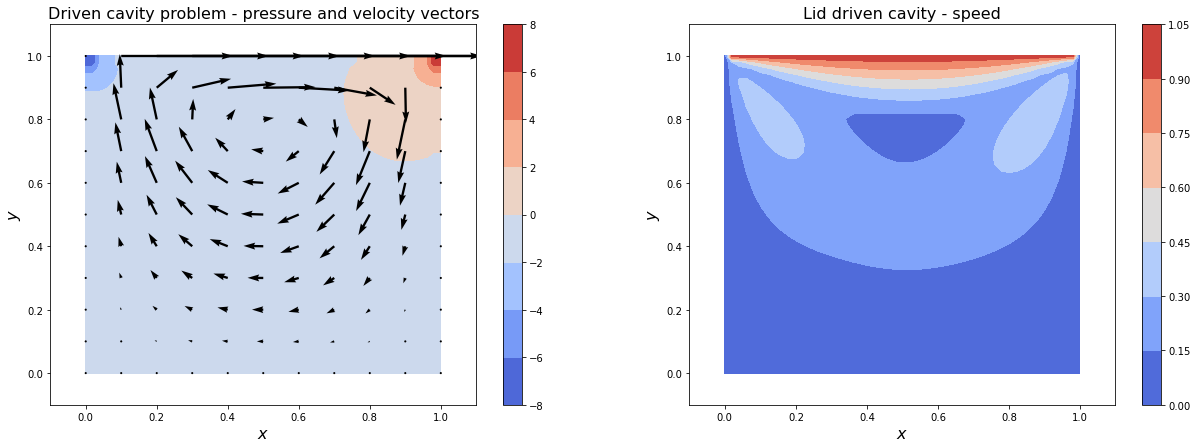

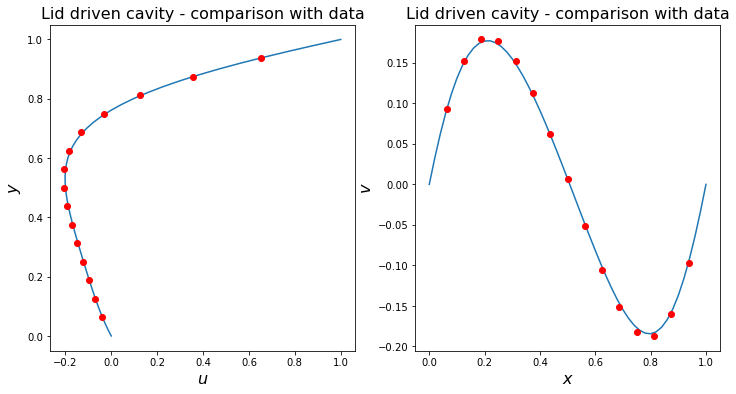

In [7]:
# set up figure
fig = plt.figure(figsize=(21, 7))
ax1 = fig.add_subplot(121)
cont = ax1.contourf(X,Y,p, cmap=cm.coolwarm)
fig.colorbar(cont)
# don't plot at every gird point - every 5th
ax1.quiver(X[::5,::5],Y[::5,::5],u[::5,::5],v[::5,::5])
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Driven cavity problem - pressure and velocity vectors', fontsize=16)

ax1 = fig.add_subplot(122)
cont = ax1.contourf(X,Y,np.sqrt(u*u+v*v), cmap=cm.coolwarm)
fig.colorbar(cont)
ax1.set_xlim(-0.1, 1.1)
ax1.set_ylim(-0.1, 1.1)
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - speed', fontsize=16)


fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(u[np.int(np.shape(u)[0]/2),:],Y[np.int(np.shape(u)[0]/2),:])
ax1.plot(Marchi_Re10_u[:,1],Marchi_Re10_u[:,0],'ro')
ax1.set_xlabel('$u$', fontsize=16)
ax1.set_ylabel('$y$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)
ax1 = fig.add_subplot(122)
ax1.plot(X[:,np.int(np.shape(u)[0]/2)],v[:,np.int(np.shape(u)[0]/2)])
ax1.plot(Marchi_Re10_v[:,0],Marchi_Re10_v[:,1],'ro')
ax1.set_xlabel('$x$', fontsize=16)
ax1.set_ylabel('$v$', fontsize=16)
ax1.set_title('Lid driven cavity - comparison with data', fontsize=16)